In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 
mach_mc = {"rs": 0.1729, "lq": 0.6986, "ld": 0.4347, "tmech":50.0, "psi_rm":0.9}

###  The Machine Parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.1729, 0.4347, 0.6986, 50.0, 0.9)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM in the d-q Coordinate
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # w
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [7]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [8]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

## 1. System Dynamics without Control

## 2. System Dynamics with Control

## 3. Controlling the System by Vector Control to Speed up, Keep Steady Speed, and Slowing Down $\omega_s$

In [9]:
#Induction machine 5x5 dynamic model 

def PMSM_dynStep2By2(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_PMSMStep2By2(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1+ B[1][0]*(-w_s*psi_rm+u2))
#     dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)

    return [dx0_dt,dx1_dt]


def mach_PMSMStep2By2(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
#     a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
#     a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
#     a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
#     b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
#     c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0
    A = ([a11,a12],[a21,a22],[a31,a32])
    B = ([b11], [b21])
    C = ([c11, c22])
    D= ([0,0],[0,0])
#     A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
#     B = ([b11], [b21], [b31])
#     C = ([c11, c22, c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [10]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]

    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.85
            isq = -1
        else:
            isd = -0.85
            isq = -1
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = -0.85
            isq = -1
        else:
            isd = 0.85
            isq = -1

In [11]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.0199
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = -1 # a = 0.0199
            isq = 0.85
        else:
            isd = -1 # a = -0.0199
            isq = -0.85
    else:
        # a < 0 to slow down, # a > 0 to speed up:
        if(isSlowingDown == 1):
            isd = -1
            isq = -0.85
        else:
            isd = -1
            isq = 0.85
#     else:
#         isd, isq = 0.0, 0.0
#     if isSlowingDown < 0:
#         # slowing down:
#         isd = 0.5
#         isq = -0.09
#     else:
#         # speeding up
#         isd = 0.2
#         isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq
        

In [12]:
def braking(w, isSlowingDown):
    print("in braking")
    print(w)
    isd, isq = 0.0, 0.0
    if(abs(w) <= zeroThresh):
        isd, isq = 0.0, 0.0
    else:
        isd, isq = calculateIsdIsqRefsBySpeedSimple(w, 1)
    print("braking: isd, isq:")
    print(isd, isq)
    return isd, isq

In [13]:
def simulateSpeedingUpWithAcceleration():
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 20*3*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    # Initializing ws:
#     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle

    kpd = ld*1
    Tid = 25.0e1

    kpq = lq*2
    Tiq = 25.0e1

    Kparamsd = [kpd,Tid]
    Kparamsq = [kpq,Tiq]
    flag = 0

#     for ii in range(0, len(Tta))
    ii =0
    isdref = 0.0
    isqref = 0.0
    isdrefs = [isdref]
    isqrefs = [isqref]
    endOfStablization = 0
    while(ii < len(Tta)):      
        #Start controller after first step
        if ii>=0:
            eid[ii] = isdref - isd[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
            eiq[ii] = isqref - isq[ii-1]
            PIeq = [eiq[ii],eiq[ii-1]]
            usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
        if(ii < len(Tta) and Tta[ii] >= 2*np.pi and Tta[ii] < 15*np.pi):
            print("Speeding up from:")
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        elif(ii < len(Tta) and Tta[ii] >= 15*np.pi and Tta[ii] < 35*np.pi):
            print("Uniform speed from:")
            print(Tta[ii])
            isdref = 0
            isqref = 0
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        else:
            print("Before Braking: w:")
            print(w[ii])
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        ii += 1
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w, me, isd, isq, np.array(isdrefs)[0:len(Tta)], np.array(isqrefs)[0:len(Tta)]

In [14]:
# import matplotlib.pyplot as pl
# %matplotlib inline
def plotDynamicForSpeedingUp(Tta, w1, me1, isd1, isq1, isdref, isqref):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the isd and isq
    pl.subplot(2,1,1)
    pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3)
    pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)

    pl.xlim(0,Tta[-1])
    pl.ylabel(r'$isd, isq$' )
    pl.xticks(np.linspace(0,Tta[-1],5))

    ax1 = pl.subplot(2,1,2)
    ax1.axhline(0)
    ax1.plot(Tta, me1, 'crimson', lw =2)
    ax1.set_yticks(np.linspace(-1.0,1.0,5))
    ax1.set_ylabel('me [p.u]')
    ax2 = ax1.twinx()
    ax2.set_ylabel('$\omega$')
    ax2.plot(Tta,w, 'peru', lw =3)

Before Braking: w:
1.2831457301089506e-06
0.0
calculate isd, isq:
-1 -0.85
Before Braking: w:
4.152665345786167e-07
0.01
calculate isd, isq:
-1 -0.85
Before Braking: w:
-2.5602978004417255e-06
0.02
calculate isd, isq:
-1 -0.85
Before Braking: w:
-7.600930023722065e-06
0.03
calculate isd, isq:
-1 -0.85
Before Braking: w:
-1.4664769467995567e-05
0.04
calculate isd, isq:
-1 -0.85
Before Braking: w:
-2.3710726212115753e-05
0.05
calculate isd, isq:
-1 -0.85
Before Braking: w:
-3.469848036213169e-05
0.06
calculate isd, isq:
-1 -0.85
Before Braking: w:
-4.758847944241968e-05
0.07
calculate isd, isq:
-1 -0.85
Before Braking: w:
-6.23419344864028e-05
0.08
calculate isd, isq:
-1 -0.85
Before Braking: w:
-7.89208151182547e-05
0.09
calculate isd, isq:
-1 -0.85
Before Braking: w:
-9.728784381447114e-05
0.1
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00011740648947483352
0.11
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00013924096039851647
0.12
calculate isd, isq:
-1 -0.85
Before Braki

3.27
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005051247326422477
3.2800000000000002
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005086340653336766
3.29
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005069777473308023
3.3000000000000003
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005002818493810457
3.31
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004886685137633494
3.3200000000000003
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00048079485321148203
3.33
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00047657453152931374
3.34
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00047592315758365007
3.35
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004787582064809307
3.36
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.000484999237924927
3.37
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004945676291516917
3.38
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005073865581512816
3.39
calculate isd, isq:
-1 0.85
Before Braking:

Speeding up from:
9.81
calculate isd, isq:
-1 -0.85
Speeding up from:
9.82
calculate isd, isq:
-1 -0.85
Speeding up from:
9.83
calculate isd, isq:
-1 -0.85
Speeding up from:
9.84
calculate isd, isq:
-1 -0.85
Speeding up from:
9.85
calculate isd, isq:
-1 -0.85
Speeding up from:
9.86
calculate isd, isq:
-1 -0.85
Speeding up from:
9.870000000000001
calculate isd, isq:
-1 -0.85
Speeding up from:
9.88
calculate isd, isq:
-1 -0.85
Speeding up from:
9.89
calculate isd, isq:
-1 -0.85
Speeding up from:
9.9
calculate isd, isq:
-1 -0.85
Speeding up from:
9.91
calculate isd, isq:
-1 -0.85
Speeding up from:
9.92
calculate isd, isq:
-1 -0.85
Speeding up from:
9.93
calculate isd, isq:
-1 -0.85
Speeding up from:
9.94
calculate isd, isq:
-1 -0.85
Speeding up from:
9.950000000000001
calculate isd, isq:
-1 -0.85
Speeding up from:
9.96
calculate isd, isq:
-1 -0.85
Speeding up from:
9.97
calculate isd, isq:
-1 -0.85
Speeding up from:
9.98
calculate isd, isq:
-1 -0.85
Speeding up from:
9.99
calculate isd, i

Speeding up from:
17.91
calculate isd, isq:
-1 -0.85
Speeding up from:
17.92
calculate isd, isq:
-1 -0.85
Speeding up from:
17.93
calculate isd, isq:
-1 -0.85
Speeding up from:
17.94
calculate isd, isq:
-1 -0.85
Speeding up from:
17.95
calculate isd, isq:
-1 -0.85
Speeding up from:
17.96
calculate isd, isq:
-1 -0.85
Speeding up from:
17.97
calculate isd, isq:
-1 -0.85
Speeding up from:
17.98
calculate isd, isq:
-1 -0.85
Speeding up from:
17.990000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
18.0
calculate isd, isq:
-1 -0.85
Speeding up from:
18.01
calculate isd, isq:
-1 -0.85
Speeding up from:
18.02
calculate isd, isq:
-1 -0.85
Speeding up from:
18.03
calculate isd, isq:
-1 -0.85
Speeding up from:
18.04
calculate isd, isq:
-1 -0.85
Speeding up from:
18.05
calculate isd, isq:
-1 -0.85
Speeding up from:
18.06
calculate isd, isq:
-1 -0.85
Speeding up from:
18.07
calculate isd, isq:
-1 -0.85
Speeding up from:
18.080000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
18.

-1 -0.85
Speeding up from:
21.580000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
21.59
calculate isd, isq:
-1 -0.85
Speeding up from:
21.6
calculate isd, isq:
-1 -0.85
Speeding up from:
21.61
calculate isd, isq:
-1 -0.85
Speeding up from:
21.62
calculate isd, isq:
-1 -0.85
Speeding up from:
21.63
calculate isd, isq:
-1 -0.85
Speeding up from:
21.64
calculate isd, isq:
-1 -0.85
Speeding up from:
21.650000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
21.66
calculate isd, isq:
-1 -0.85
Speeding up from:
21.67
calculate isd, isq:
-1 -0.85
Speeding up from:
21.68
calculate isd, isq:
-1 -0.85
Speeding up from:
21.69
calculate isd, isq:
-1 -0.85
Speeding up from:
21.7
calculate isd, isq:
-1 -0.85
Speeding up from:
21.71
calculate isd, isq:
-1 -0.85
Speeding up from:
21.72
calculate isd, isq:
-1 -0.85
Speeding up from:
21.73
calculate isd, isq:
-1 -0.85
Speeding up from:
21.740000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
21.75
calculate isd, isq:
-1 -0.85


Speeding up from:
28.48
calculate isd, isq:
-1 -0.85
Speeding up from:
28.490000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
28.5
calculate isd, isq:
-1 -0.85
Speeding up from:
28.51
calculate isd, isq:
-1 -0.85
Speeding up from:
28.52
calculate isd, isq:
-1 -0.85
Speeding up from:
28.53
calculate isd, isq:
-1 -0.85
Speeding up from:
28.54
calculate isd, isq:
-1 -0.85
Speeding up from:
28.55
calculate isd, isq:
-1 -0.85
Speeding up from:
28.560000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
28.57
calculate isd, isq:
-1 -0.85
Speeding up from:
28.580000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
28.59
calculate isd, isq:
-1 -0.85
Speeding up from:
28.6
calculate isd, isq:
-1 -0.85
Speeding up from:
28.61
calculate isd, isq:
-1 -0.85
Speeding up from:
28.62
calculate isd, isq:
-1 -0.85
Speeding up from:
28.63
calculate isd, isq:
-1 -0.85
Speeding up from:
28.64
calculate isd, isq:
-1 -0.85
Speeding up from:
28.650000000000002
calculate isd, isq:
-1 -0

Speeding up from:
31.14
calculate isd, isq:
-1 -0.85
Speeding up from:
31.150000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
31.16
calculate isd, isq:
-1 -0.85
Speeding up from:
31.17
calculate isd, isq:
-1 -0.85
Speeding up from:
31.18
calculate isd, isq:
-1 -0.85
Speeding up from:
31.19
calculate isd, isq:
-1 -0.85
Speeding up from:
31.2
calculate isd, isq:
-1 -0.85
Speeding up from:
31.21
calculate isd, isq:
-1 -0.85
Speeding up from:
31.220000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
31.23
calculate isd, isq:
-1 -0.85
Speeding up from:
31.240000000000002
calculate isd, isq:
-1 -0.85
Speeding up from:
31.25
calculate isd, isq:
-1 -0.85
Speeding up from:
31.26
calculate isd, isq:
-1 -0.85
Speeding up from:
31.27
calculate isd, isq:
-1 -0.85
Speeding up from:
31.28
calculate isd, isq:
-1 -0.85
Speeding up from:
31.29
calculate isd, isq:
-1 -0.85
Speeding up from:
31.3
calculate isd, isq:
-1 -0.85
Speeding up from:
31.310000000000002
calculate isd, isq:
-1 -0

Speeding up from:
38.62
calculate isd, isq:
-1 -0.85
Speeding up from:
38.63
calculate isd, isq:
-1 -0.85
Speeding up from:
38.64
calculate isd, isq:
-1 -0.85
Speeding up from:
38.65
calculate isd, isq:
-1 -0.85
Speeding up from:
38.660000000000004
calculate isd, isq:
-1 -0.85
Speeding up from:
38.67
calculate isd, isq:
-1 -0.85
Speeding up from:
38.68
calculate isd, isq:
-1 -0.85
Speeding up from:
38.69
calculate isd, isq:
-1 -0.85
Speeding up from:
38.7
calculate isd, isq:
-1 -0.85
Speeding up from:
38.71
calculate isd, isq:
-1 -0.85
Speeding up from:
38.72
calculate isd, isq:
-1 -0.85
Speeding up from:
38.730000000000004
calculate isd, isq:
-1 -0.85
Speeding up from:
38.74
calculate isd, isq:
-1 -0.85
Speeding up from:
38.75
calculate isd, isq:
-1 -0.85
Speeding up from:
38.76
calculate isd, isq:
-1 -0.85
Speeding up from:
38.77
calculate isd, isq:
-1 -0.85
Speeding up from:
38.78
calculate isd, isq:
-1 -0.85
Speeding up from:
38.79
calculate isd, isq:
-1 -0.85
Speeding up from:
38.

calculate isd, isq:
-1 -0.85
Speeding up from:
46.87
calculate isd, isq:
-1 -0.85
Speeding up from:
46.88
calculate isd, isq:
-1 -0.85
Speeding up from:
46.89
calculate isd, isq:
-1 -0.85
Speeding up from:
46.9
calculate isd, isq:
-1 -0.85
Speeding up from:
46.910000000000004
calculate isd, isq:
-1 -0.85
Speeding up from:
46.92
calculate isd, isq:
-1 -0.85
Speeding up from:
46.93
calculate isd, isq:
-1 -0.85
Speeding up from:
46.94
calculate isd, isq:
-1 -0.85
Speeding up from:
46.95
calculate isd, isq:
-1 -0.85
Speeding up from:
46.96
calculate isd, isq:
-1 -0.85
Speeding up from:
46.97
calculate isd, isq:
-1 -0.85
Speeding up from:
46.980000000000004
calculate isd, isq:
-1 -0.85
Speeding up from:
46.99
calculate isd, isq:
-1 -0.85
Speeding up from:
47.0
calculate isd, isq:
-1 -0.85
Speeding up from:
47.01
calculate isd, isq:
-1 -0.85
Speeding up from:
47.02
calculate isd, isq:
-1 -0.85
Speeding up from:
47.03
calculate isd, isq:
-1 -0.85
Speeding up from:
47.04
calculate isd, isq:
-1

Uniform speed from:
53.09
Uniform speed from:
53.1
Uniform speed from:
53.11
Uniform speed from:
53.120000000000005
Uniform speed from:
53.13
Uniform speed from:
53.14
Uniform speed from:
53.15
Uniform speed from:
53.160000000000004
Uniform speed from:
53.17
Uniform speed from:
53.18
Uniform speed from:
53.19
Uniform speed from:
53.2
Uniform speed from:
53.21
Uniform speed from:
53.22
Uniform speed from:
53.230000000000004
Uniform speed from:
53.24
Uniform speed from:
53.25
Uniform speed from:
53.26
Uniform speed from:
53.27
Uniform speed from:
53.28
Uniform speed from:
53.29
Uniform speed from:
53.300000000000004
Uniform speed from:
53.31
Uniform speed from:
53.32
Uniform speed from:
53.33
Uniform speed from:
53.34
Uniform speed from:
53.35
Uniform speed from:
53.36
Uniform speed from:
53.370000000000005
Uniform speed from:
53.38
Uniform speed from:
53.39
Uniform speed from:
53.4
Uniform speed from:
53.410000000000004
Uniform speed from:
53.42
Uniform speed from:
53.43
Uniform speed f

Uniform speed from:
65.37
Uniform speed from:
65.38
Uniform speed from:
65.39
Uniform speed from:
65.4
Uniform speed from:
65.41
Uniform speed from:
65.42
Uniform speed from:
65.43
Uniform speed from:
65.44
Uniform speed from:
65.45
Uniform speed from:
65.46000000000001
Uniform speed from:
65.47
Uniform speed from:
65.48
Uniform speed from:
65.49
Uniform speed from:
65.5
Uniform speed from:
65.51
Uniform speed from:
65.52
Uniform speed from:
65.53
Uniform speed from:
65.54
Uniform speed from:
65.55
Uniform speed from:
65.56
Uniform speed from:
65.57000000000001
Uniform speed from:
65.58
Uniform speed from:
65.59
Uniform speed from:
65.6
Uniform speed from:
65.61
Uniform speed from:
65.62
Uniform speed from:
65.63
Uniform speed from:
65.64
Uniform speed from:
65.65
Uniform speed from:
65.66
Uniform speed from:
65.67
Uniform speed from:
65.68
Uniform speed from:
65.69
Uniform speed from:
65.7
Uniform speed from:
65.71000000000001
Uniform speed from:
65.72
Uniform speed from:
65.73
Unifor

72.32000000000001
Uniform speed from:
72.33
Uniform speed from:
72.34
Uniform speed from:
72.35000000000001
Uniform speed from:
72.36
Uniform speed from:
72.37
Uniform speed from:
72.38
Uniform speed from:
72.39
Uniform speed from:
72.4
Uniform speed from:
72.41
Uniform speed from:
72.42
Uniform speed from:
72.43
Uniform speed from:
72.44
Uniform speed from:
72.45
Uniform speed from:
72.46000000000001
Uniform speed from:
72.47
Uniform speed from:
72.48
Uniform speed from:
72.49
Uniform speed from:
72.5
Uniform speed from:
72.51
Uniform speed from:
72.52
Uniform speed from:
72.53
Uniform speed from:
72.54
Uniform speed from:
72.55
Uniform speed from:
72.56
Uniform speed from:
72.57000000000001
Uniform speed from:
72.58
Uniform speed from:
72.59
Uniform speed from:
72.60000000000001
Uniform speed from:
72.61
Uniform speed from:
72.62
Uniform speed from:
72.63
Uniform speed from:
72.64
Uniform speed from:
72.65
Uniform speed from:
72.66
Uniform speed from:
72.67
Uniform speed from:
72.68


Uniform speed from:
87.05
Uniform speed from:
87.06
Uniform speed from:
87.07000000000001
Uniform speed from:
87.08
Uniform speed from:
87.09
Uniform speed from:
87.10000000000001
Uniform speed from:
87.11
Uniform speed from:
87.12
Uniform speed from:
87.13
Uniform speed from:
87.14
Uniform speed from:
87.15
Uniform speed from:
87.16
Uniform speed from:
87.17
Uniform speed from:
87.18
Uniform speed from:
87.19
Uniform speed from:
87.2
Uniform speed from:
87.21000000000001
Uniform speed from:
87.22
Uniform speed from:
87.23
Uniform speed from:
87.24
Uniform speed from:
87.25
Uniform speed from:
87.26
Uniform speed from:
87.27
Uniform speed from:
87.28
Uniform speed from:
87.29
Uniform speed from:
87.3
Uniform speed from:
87.31
Uniform speed from:
87.32000000000001
Uniform speed from:
87.33
Uniform speed from:
87.34
Uniform speed from:
87.35000000000001
Uniform speed from:
87.36
Uniform speed from:
87.37
Uniform speed from:
87.38
Uniform speed from:
87.39
Uniform speed from:
87.4
Uniform

Uniform speed from:
100.18
Uniform speed from:
100.19
Uniform speed from:
100.2
Uniform speed from:
100.21000000000001
Uniform speed from:
100.22
Uniform speed from:
100.23
Uniform speed from:
100.24000000000001
Uniform speed from:
100.25
Uniform speed from:
100.26
Uniform speed from:
100.27
Uniform speed from:
100.28
Uniform speed from:
100.29
Uniform speed from:
100.3
Uniform speed from:
100.31
Uniform speed from:
100.32000000000001
Uniform speed from:
100.33
Uniform speed from:
100.34
Uniform speed from:
100.35000000000001
Uniform speed from:
100.36
Uniform speed from:
100.37
Uniform speed from:
100.38
Uniform speed from:
100.39
Uniform speed from:
100.4
Uniform speed from:
100.41
Uniform speed from:
100.42
Uniform speed from:
100.43
Uniform speed from:
100.44
Uniform speed from:
100.45
Uniform speed from:
100.46000000000001
Uniform speed from:
100.47
Uniform speed from:
100.48
Uniform speed from:
100.49000000000001
Uniform speed from:
100.5
Uniform speed from:
100.51
Uniform speed 

Uniform speed from:
104.4
Uniform speed from:
104.41
Uniform speed from:
104.42
Uniform speed from:
104.43
Uniform speed from:
104.44
Uniform speed from:
104.45
Uniform speed from:
104.46000000000001
Uniform speed from:
104.47
Uniform speed from:
104.48
Uniform speed from:
104.49000000000001
Uniform speed from:
104.5
Uniform speed from:
104.51
Uniform speed from:
104.52
Uniform speed from:
104.53
Uniform speed from:
104.54
Uniform speed from:
104.55
Uniform speed from:
104.56
Uniform speed from:
104.57000000000001
Uniform speed from:
104.58
Uniform speed from:
104.59
Uniform speed from:
104.60000000000001
Uniform speed from:
104.61
Uniform speed from:
104.62
Uniform speed from:
104.63
Uniform speed from:
104.64
Uniform speed from:
104.65
Uniform speed from:
104.66
Uniform speed from:
104.67
Uniform speed from:
104.68
Uniform speed from:
104.69
Uniform speed from:
104.7
Uniform speed from:
104.71000000000001
Uniform speed from:
104.72
Uniform speed from:
104.73
Uniform speed from:
104.7

110.39
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8730286205858029
110.4
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.872916617243911
110.41
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8728028455304129
110.42
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8726873286835357
110.43
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8725700895690512
110.44
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8724511506887107
110.45
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8723305341884324
110.46000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8722082618662492
110.47
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8720843551800281
110.48
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8719588352549678
110.49000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.871831722890882
110.5
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8717030385692782
110.51
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.8715728024602376
110.52
calculate i

-1 0.85
Before Braking: w:
-0.7963034822120663
113.94
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7960696945969733
113.95
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7958359836017805
113.96000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7956023493579453
113.97
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7953687919910086
113.98
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7951353116206659
113.99000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7949019083608364
114.0
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7946685823197323
114.01
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7944353335999272
114.02
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7942021622984246
114.03
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7939690685067247
114.04
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7937360523108916
114.05
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.7935031137916191
114.06
calculate isd, isq:
-1 0.85
Before 

Before Braking: w:
-0.6618338746532398
120.08
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6616202732232107
120.09
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6614066718191391
120.10000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6611930704161331
120.11
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6609794689895186
120.12
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6607658675148389
120.13
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.660552265967853
120.14
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6603386643245343
120.15
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6601250625610697
120.16
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6599114606538581
120.17
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6596978585795086
120.18
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6594842563148401
120.19
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.6592706538368795
120.2
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.659057

Before Braking: w:
-0.5312576588678009
126.18
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5310431509645774
126.19
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5308286421228947
126.2
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5306141323452808
126.21000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.530399621634258
126.22
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5301851099923429
126.23
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5299705974220458
126.24000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5297560839258713
126.25
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5295415695063181
126.26
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5293270541658793
126.27
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5291125379070417
126.28
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5288980207322863
126.29
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.5286835026440884
126.3
calculate isd, isq:
-1 0.85
Before Braking: w

133.12
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.38204261008189666
133.13
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3818278084121327
133.14000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3816130065835482
133.15
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.38139820459646273
133.16
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3811834024511977
133.17000000000002
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.38096860014807593
133.18
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.38075379768742146
133.19
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3805389950695597
133.2
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3803241922948174
133.21
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3801093893635224
133.22
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3798945862760038
133.23
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3796797830325918
133.24
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.37946497963361764
133.25
cal

Before Braking: w:
-0.32962715269105275
135.57
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.32941232272339976
135.58
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3291974926750387
135.59
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3289826625461644
135.6
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.32876783233697116
135.61
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.32855300204765253
135.62
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.32833817167840185
135.63
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.32812334122941167
135.64000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3279085107008741
135.65
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3276936800929808
135.66
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.32747884940592276
135.67000000000002
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3272640186398907
135.68
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.3270491877950745
135.69
calculate isd, isq:
-1 0.85
Before B

Before Braking: w:
-0.19792659182843741
141.70000000000002
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19771173608474096
141.71
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.1974968803230502
141.72
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19728202454340982
141.73
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.1970671687458643
141.74
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19685231293045807
141.75
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19663745709723535
141.76
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19642260124624045
141.77
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19620774537751734
141.78
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19599288949111007
141.79
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19577803358706253
141.8
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19556317766541848
141.81
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.19534832172622144
141.82
calculate isd, isq:
-1 0.85
Before Braking: 

-1 0.85
Before Braking: w:
-0.11198320930035967
145.70000000000002
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11176834882506262
145.71
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11155348834482069
145.72
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11133862785963454
145.73
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11112376736950491
145.74
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11090890687443267
145.75
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11069404637441868
145.76
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11047918586946401
145.77
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11026432535956976
145.78
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.11004946484473713
145.79
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.10983460432496742
145.8
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.10961974380026199
145.81
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.10940488327062228
145.82
calculate isd, isq:
-1 0.85
Before

-1 -0.85
Before Braking: w:
-0.000453298564069623
153.51
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00044746541538436663
153.52
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00044560391639907233
153.53
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00044761997600305627
153.54
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00045342168865593704
153.55
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00046291927053560954
153.56
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004760249343877974
153.57
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004926528736395857
153.58
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005127192330287604
153.59
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005281099892673093
153.6
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005389380920236605
153.61
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005453130653959594
153.62
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005473411373160615
153.63
calcula

calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005154398107958564
157.18
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005044792398201689
157.19
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004894121199306104
157.20000000000002
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00047877493234362804
157.21
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004724624518091607
157.22
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00047037177278296964
157.23
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004724022577247723
157.24
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004784556178153228
157.25
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004884358620620205
157.26
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005022491521951243
157.27
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005113619245537548
157.28
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005158881459274586
157.29
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.00051

Before Braking: w:
-0.0004951021301018784
163.02
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005038446724633808
163.03
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005080525370280301
163.04
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005078354070814137
163.05
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005032998310465258
163.06
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004945488511178759
163.07
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004902632738373339
163.08
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.000490336030814182
163.09
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004946623031651712
163.1
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005031400898847798
163.11
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005070901225419518
163.12
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005066218844232118
163.13
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005018416859906851
163.14000000000001
calculate is

Before Braking: w:
-0.0004968706834276248
168.54
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004964055473571129
168.55
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.000500241963950014
168.56
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004996836565181097
168.57
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005034292652407613
168.58
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005027826138019899
168.59
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004978493161175424
168.6
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004973252390112898
168.61
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.000501104295732109
168.62
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005004901711981951
168.63
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004955885128235871
168.64000000000001
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004950953634664914
168.65
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004989046487508088
168.66
calculate i

Before Braking: w:
-0.0004981363649550512
172.91
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005005828760646099
172.92000000000002
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004986719750480527
172.93
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005011028446829052
172.94
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004991767286107197
172.95000000000002
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005015927700861388
172.96
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004996522292343103
172.97
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005020542129034732
172.98
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005000999958268852
172.99
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.000493894039505339
173.0
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004921330235771169
173.01
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004947100851468752
173.02
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005015208985353248
173.0

Before Braking: w:
-0.0005009248132523923
179.8
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004900578254960208
179.81
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004837487899864094
179.82
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004818883442027303
179.83
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.00048436953735554755
179.84
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004910879488744355
179.85
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005019415767873806
179.86
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005082366282196148
179.87
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005100835932206916
179.88
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005075897200376754
179.89000000000001
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.000500858974112235
179.9
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004899922266263269
179.91
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.000483683429960409
179.92000000000002


Before Braking: w:
-0.0005046086659121916
183.51
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004979355744647281
183.52
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004957201264938633
183.53
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004978551760131644
183.54
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005042360805321664
183.55
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005061663347177351
183.56
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005037532674011636
183.57
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004971009288046509
183.58
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004949057185031262
183.59
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004970605015944639
183.6
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005034606481494198
183.61
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005054096135118555
183.62
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005030147426907253
183.63
calculate isd, isq:
-1

Before Braking: w:
-0.0005022311672635599
187.73
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004956075241255766
187.74
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004934403227016759
187.75
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004956224425169272
187.76
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005020492701536656
187.77
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005040241833455634
187.78
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005016545501399533
187.79
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0004950444623033692
187.8
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004928904815778633
187.81
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0004950854946942996
187.82
calculate isd, isq:
-1 -0.85
Before Braking: w:
-0.0005015248964110805
187.83
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005035120472548919
187.84
calculate isd, isq:
-1 0.85
Before Braking: w:
-0.0005011543254315202
187.85
calculate isd, isq:
-1

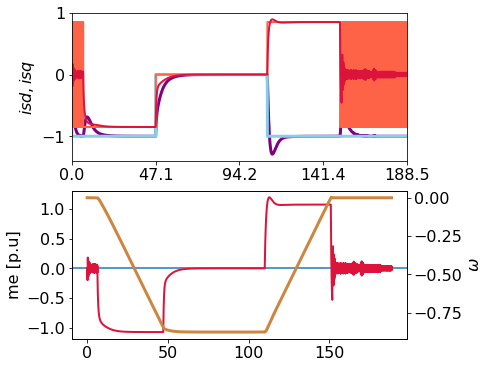

In [15]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [16]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.002
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.2
            isq = 0.105
        else:
            isd = 0.5
            isq = -0.09
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.5
            isq = -0.09
        else:
            isd = 0.2
            isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq

Before Braking: w:
1.2831457301089506e-06
0.0
calculate isd, isq:
0.5 -0.09
Before Braking: w:
3.4487364771790176e-06
0.01
calculate isd, isq:
0.5 -0.09
Before Braking: w:
6.464466396196482e-06
0.02
calculate isd, isq:
0.5 -0.09
Before Braking: w:
1.029898711753588e-05
0.03
calculate isd, isq:
0.5 -0.09
Before Braking: w:
1.4921921296415881e-05
0.04
calculate isd, isq:
0.5 -0.09
Before Braking: w:
2.0303833041626293e-05
0.05
calculate isd, isq:
0.5 -0.09
Before Braking: w:
2.641619845422877e-05
0.06
calculate isd, isq:
0.5 -0.09
Before Braking: w:
3.323137689484074e-05
0.07
calculate isd, isq:
0.5 -0.09
Before Braking: w:
4.072258308028152e-05
0.08
calculate isd, isq:
0.5 -0.09
Before Braking: w:
4.88638600478538e-05
0.09
calculate isd, isq:
0.5 -0.09
Before Braking: w:
5.7630052451128e-05
0.1
calculate isd, isq:
0.5 -0.09
Before Braking: w:
6.699678129505268e-05
0.11
calculate isd, isq:
0.5 -0.09
Before Braking: w:
7.694042012797338e-05
0.12
calculate isd, isq:
0.5 -0.09
Before Brakin

0.5 -0.09
Before Braking: w:
0.00146969321349249
5.15
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0014595209395959047
5.16
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.001449329033614723
5.17
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.001439117594564888
5.18
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.001428886720880763
5.19
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0014186365104184246
5.2
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0014083670604589393
5.21
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.001398078467711627
5.22
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0013877708283173056
5.23
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0013774442378515176
5.24
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.001367098791327748
5.25
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0013567345832006205
5.26
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0013463517073690782
5.2700000000000005
calculate isd, isq:
0.5 -0

Speeding up from:
9.040000000000001
calculate isd, isq:
0.2 0.105
Speeding up from:
9.05
calculate isd, isq:
0.2 0.105
Speeding up from:
9.06
calculate isd, isq:
0.2 0.105
Speeding up from:
9.07
calculate isd, isq:
0.2 0.105
Speeding up from:
9.08
calculate isd, isq:
0.2 0.105
Speeding up from:
9.09
calculate isd, isq:
0.2 0.105
Speeding up from:
9.1
calculate isd, isq:
0.2 0.105
Speeding up from:
9.11
calculate isd, isq:
0.2 0.105
Speeding up from:
9.120000000000001
calculate isd, isq:
0.2 0.105
Speeding up from:
9.13
calculate isd, isq:
0.2 0.105
Speeding up from:
9.14
calculate isd, isq:
0.2 0.105
Speeding up from:
9.15
calculate isd, isq:
0.2 0.105
Speeding up from:
9.16
calculate isd, isq:
0.2 0.105
Speeding up from:
9.17
calculate isd, isq:
0.2 0.105
Speeding up from:
9.18
calculate isd, isq:
0.2 0.105
Speeding up from:
9.19
calculate isd, isq:
0.2 0.105
Speeding up from:
9.200000000000001
calculate isd, isq:
0.2 0.105
Speeding up from:
9.21
calculate isd, isq:
0.2 0.105
Speeding

17.6
calculate isd, isq:
0.2 0.105
Speeding up from:
17.61
calculate isd, isq:
0.2 0.105
Speeding up from:
17.62
calculate isd, isq:
0.2 0.105
Speeding up from:
17.63
calculate isd, isq:
0.2 0.105
Speeding up from:
17.64
calculate isd, isq:
0.2 0.105
Speeding up from:
17.650000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
17.66
calculate isd, isq:
0.2 0.105
Speeding up from:
17.67
calculate isd, isq:
0.2 0.105
Speeding up from:
17.68
calculate isd, isq:
0.2 0.105
Speeding up from:
17.69
calculate isd, isq:
0.2 0.105
Speeding up from:
17.7
calculate isd, isq:
0.2 0.105
Speeding up from:
17.71
calculate isd, isq:
0.2 0.105
Speeding up from:
17.72
calculate isd, isq:
0.2 0.105
Speeding up from:
17.73
calculate isd, isq:
0.2 0.105
Speeding up from:
17.740000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
17.75
calculate isd, isq:
0.2 0.105
Speeding up from:
17.76
calculate isd, isq:
0.2 0.105
Speeding up from:
17.77
calculate isd, isq:
0.2 0.105
Speeding up from:
17.7

0.2 0.105
Speeding up from:
22.07
calculate isd, isq:
0.2 0.105
Speeding up from:
22.080000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
22.09
calculate isd, isq:
0.2 0.105
Speeding up from:
22.1
calculate isd, isq:
0.2 0.105
Speeding up from:
22.11
calculate isd, isq:
0.2 0.105
Speeding up from:
22.12
calculate isd, isq:
0.2 0.105
Speeding up from:
22.13
calculate isd, isq:
0.2 0.105
Speeding up from:
22.14
calculate isd, isq:
0.2 0.105
Speeding up from:
22.150000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
22.16
calculate isd, isq:
0.2 0.105
Speeding up from:
22.17
calculate isd, isq:
0.2 0.105
Speeding up from:
22.18
calculate isd, isq:
0.2 0.105
Speeding up from:
22.19
calculate isd, isq:
0.2 0.105
Speeding up from:
22.2
calculate isd, isq:
0.2 0.105
Speeding up from:
22.21
calculate isd, isq:
0.2 0.105
Speeding up from:
22.22
calculate isd, isq:
0.2 0.105
Speeding up from:
22.23
calculate isd, isq:
0.2 0.105
Speeding up from:
22.240000000000002
calculate i

28.42
calculate isd, isq:
0.2 0.105
Speeding up from:
28.43
calculate isd, isq:
0.2 0.105
Speeding up from:
28.44
calculate isd, isq:
0.2 0.105
Speeding up from:
28.45
calculate isd, isq:
0.2 0.105
Speeding up from:
28.46
calculate isd, isq:
0.2 0.105
Speeding up from:
28.47
calculate isd, isq:
0.2 0.105
Speeding up from:
28.48
calculate isd, isq:
0.2 0.105
Speeding up from:
28.490000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
28.5
calculate isd, isq:
0.2 0.105
Speeding up from:
28.51
calculate isd, isq:
0.2 0.105
Speeding up from:
28.52
calculate isd, isq:
0.2 0.105
Speeding up from:
28.53
calculate isd, isq:
0.2 0.105
Speeding up from:
28.54
calculate isd, isq:
0.2 0.105
Speeding up from:
28.55
calculate isd, isq:
0.2 0.105
Speeding up from:
28.560000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
28.57
calculate isd, isq:
0.2 0.105
Speeding up from:
28.580000000000002
calculate isd, isq:
0.2 0.105
Speeding up from:
28.59
calculate isd, isq:
0.2 0.105
Speeding

35.37
calculate isd, isq:
0.2 0.105
Speeding up from:
35.38
calculate isd, isq:
0.2 0.105
Speeding up from:
35.39
calculate isd, isq:
0.2 0.105
Speeding up from:
35.4
calculate isd, isq:
0.2 0.105
Speeding up from:
35.410000000000004
calculate isd, isq:
0.2 0.105
Speeding up from:
35.42
calculate isd, isq:
0.2 0.105
Speeding up from:
35.43
calculate isd, isq:
0.2 0.105
Speeding up from:
35.44
calculate isd, isq:
0.2 0.105
Speeding up from:
35.45
calculate isd, isq:
0.2 0.105
Speeding up from:
35.46
calculate isd, isq:
0.2 0.105
Speeding up from:
35.47
calculate isd, isq:
0.2 0.105
Speeding up from:
35.480000000000004
calculate isd, isq:
0.2 0.105
Speeding up from:
35.49
calculate isd, isq:
0.2 0.105
Speeding up from:
35.5
calculate isd, isq:
0.2 0.105
Speeding up from:
35.51
calculate isd, isq:
0.2 0.105
Speeding up from:
35.52
calculate isd, isq:
0.2 0.105
Speeding up from:
35.53
calculate isd, isq:
0.2 0.105
Speeding up from:
35.54
calculate isd, isq:
0.2 0.105
Speeding up from:
35.5

0.2 0.105
Speeding up from:
43.76
calculate isd, isq:
0.2 0.105
Speeding up from:
43.77
calculate isd, isq:
0.2 0.105
Speeding up from:
43.78
calculate isd, isq:
0.2 0.105
Speeding up from:
43.79
calculate isd, isq:
0.2 0.105
Speeding up from:
43.800000000000004
calculate isd, isq:
0.2 0.105
Speeding up from:
43.81
calculate isd, isq:
0.2 0.105
Speeding up from:
43.82
calculate isd, isq:
0.2 0.105
Speeding up from:
43.83
calculate isd, isq:
0.2 0.105
Speeding up from:
43.84
calculate isd, isq:
0.2 0.105
Speeding up from:
43.85
calculate isd, isq:
0.2 0.105
Speeding up from:
43.86
calculate isd, isq:
0.2 0.105
Speeding up from:
43.87
calculate isd, isq:
0.2 0.105
Speeding up from:
43.88
calculate isd, isq:
0.2 0.105
Speeding up from:
43.89
calculate isd, isq:
0.2 0.105
Speeding up from:
43.9
calculate isd, isq:
0.2 0.105
Speeding up from:
43.910000000000004
calculate isd, isq:
0.2 0.105
Speeding up from:
43.92
calculate isd, isq:
0.2 0.105
Speeding up from:
43.93
calculate isd, isq:
0.2

Uniform speed from:
48.01
Uniform speed from:
48.02
Uniform speed from:
48.03
Uniform speed from:
48.04
Uniform speed from:
48.050000000000004
Uniform speed from:
48.06
Uniform speed from:
48.07
Uniform speed from:
48.08
Uniform speed from:
48.09
Uniform speed from:
48.1
Uniform speed from:
48.11
Uniform speed from:
48.120000000000005
Uniform speed from:
48.13
Uniform speed from:
48.14
Uniform speed from:
48.15
Uniform speed from:
48.160000000000004
Uniform speed from:
48.17
Uniform speed from:
48.18
Uniform speed from:
48.19
Uniform speed from:
48.2
Uniform speed from:
48.21
Uniform speed from:
48.22
Uniform speed from:
48.230000000000004
Uniform speed from:
48.24
Uniform speed from:
48.25
Uniform speed from:
48.26
Uniform speed from:
48.27
Uniform speed from:
48.28
Uniform speed from:
48.29
Uniform speed from:
48.300000000000004
Uniform speed from:
48.31
Uniform speed from:
48.32
Uniform speed from:
48.33
Uniform speed from:
48.34
Uniform speed from:
48.35
Uniform speed from:
48.36
U

Uniform speed from:
61.74
Uniform speed from:
61.75
Uniform speed from:
61.76
Uniform speed from:
61.77
Uniform speed from:
61.78
Uniform speed from:
61.79
Uniform speed from:
61.800000000000004
Uniform speed from:
61.81
Uniform speed from:
61.82
Uniform speed from:
61.83
Uniform speed from:
61.84
Uniform speed from:
61.85
Uniform speed from:
61.86
Uniform speed from:
61.870000000000005
Uniform speed from:
61.88
Uniform speed from:
61.89
Uniform speed from:
61.9
Uniform speed from:
61.910000000000004
Uniform speed from:
61.92
Uniform speed from:
61.93
Uniform speed from:
61.940000000000005
Uniform speed from:
61.95
Uniform speed from:
61.96
Uniform speed from:
61.97
Uniform speed from:
61.980000000000004
Uniform speed from:
61.99
Uniform speed from:
62.0
Uniform speed from:
62.01
Uniform speed from:
62.02
Uniform speed from:
62.03
Uniform speed from:
62.04
Uniform speed from:
62.050000000000004
Uniform speed from:
62.06
Uniform speed from:
62.07
Uniform speed from:
62.08
Uniform speed 

Uniform speed from:
67.99
Uniform speed from:
68.0
Uniform speed from:
68.01
Uniform speed from:
68.02
Uniform speed from:
68.03
Uniform speed from:
68.04
Uniform speed from:
68.05
Uniform speed from:
68.06
Uniform speed from:
68.07000000000001
Uniform speed from:
68.08
Uniform speed from:
68.09
Uniform speed from:
68.1
Uniform speed from:
68.11
Uniform speed from:
68.12
Uniform speed from:
68.13
Uniform speed from:
68.14
Uniform speed from:
68.15
Uniform speed from:
68.16
Uniform speed from:
68.17
Uniform speed from:
68.18
Uniform speed from:
68.19
Uniform speed from:
68.2
Uniform speed from:
68.21000000000001
Uniform speed from:
68.22
Uniform speed from:
68.23
Uniform speed from:
68.24
Uniform speed from:
68.25
Uniform speed from:
68.26
Uniform speed from:
68.27
Uniform speed from:
68.28
Uniform speed from:
68.29
Uniform speed from:
68.3
Uniform speed from:
68.31
Uniform speed from:
68.32000000000001
Uniform speed from:
68.33
Uniform speed from:
68.34
Uniform speed from:
68.350000000

Uniform speed from:
81.51
Uniform speed from:
81.52
Uniform speed from:
81.53
Uniform speed from:
81.54
Uniform speed from:
81.55
Uniform speed from:
81.56
Uniform speed from:
81.57000000000001
Uniform speed from:
81.58
Uniform speed from:
81.59
Uniform speed from:
81.60000000000001
Uniform speed from:
81.61
Uniform speed from:
81.62
Uniform speed from:
81.63
Uniform speed from:
81.64
Uniform speed from:
81.65
Uniform speed from:
81.66
Uniform speed from:
81.67
Uniform speed from:
81.68
Uniform speed from:
81.69
Uniform speed from:
81.7
Uniform speed from:
81.71000000000001
Uniform speed from:
81.72
Uniform speed from:
81.73
Uniform speed from:
81.74
Uniform speed from:
81.75
Uniform speed from:
81.76
Uniform speed from:
81.77
Uniform speed from:
81.78
Uniform speed from:
81.79
Uniform speed from:
81.8
Uniform speed from:
81.81
Uniform speed from:
81.82000000000001
Uniform speed from:
81.83
Uniform speed from:
81.84
Uniform speed from:
81.85000000000001
Uniform speed from:
81.86
Unifor

Uniform speed from:
96.67
Uniform speed from:
96.68
Uniform speed from:
96.69
Uniform speed from:
96.7
Uniform speed from:
96.71000000000001
Uniform speed from:
96.72
Uniform speed from:
96.73
Uniform speed from:
96.74000000000001
Uniform speed from:
96.75
Uniform speed from:
96.76
Uniform speed from:
96.77
Uniform speed from:
96.78
Uniform speed from:
96.79
Uniform speed from:
96.8
Uniform speed from:
96.81
Uniform speed from:
96.82000000000001
Uniform speed from:
96.83
Uniform speed from:
96.84
Uniform speed from:
96.85000000000001
Uniform speed from:
96.86
Uniform speed from:
96.87
Uniform speed from:
96.88
Uniform speed from:
96.89
Uniform speed from:
96.9
Uniform speed from:
96.91
Uniform speed from:
96.92
Uniform speed from:
96.93
Uniform speed from:
96.94
Uniform speed from:
96.95
Uniform speed from:
96.96000000000001
Uniform speed from:
96.97
Uniform speed from:
96.98
Uniform speed from:
96.99000000000001
Uniform speed from:
97.0
Uniform speed from:
97.01
Uniform speed from:
97

Uniform speed from:
104.66
Uniform speed from:
104.67
Uniform speed from:
104.68
Uniform speed from:
104.69
Uniform speed from:
104.7
Uniform speed from:
104.71000000000001
Uniform speed from:
104.72
Uniform speed from:
104.73
Uniform speed from:
104.74000000000001
Uniform speed from:
104.75
Uniform speed from:
104.76
Uniform speed from:
104.77
Uniform speed from:
104.78
Uniform speed from:
104.79
Uniform speed from:
104.8
Uniform speed from:
104.81
Uniform speed from:
104.82000000000001
Uniform speed from:
104.83
Uniform speed from:
104.84
Uniform speed from:
104.85000000000001
Uniform speed from:
104.86
Uniform speed from:
104.87
Uniform speed from:
104.88
Uniform speed from:
104.89
Uniform speed from:
104.9
Uniform speed from:
104.91
Uniform speed from:
104.92
Uniform speed from:
104.93
Uniform speed from:
104.94
Uniform speed from:
104.95
Uniform speed from:
104.96000000000001
Uniform speed from:
104.97
Uniform speed from:
104.98
Uniform speed from:
104.99000000000001
Uniform speed

0.5 -0.09
Before Braking: w:
0.07580118805088214
115.33
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0757824772868183
115.34
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07576377877381414
115.35000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0757450924736201
115.36
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07572641834796323
115.37
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07570775635854904
115.38
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07568910646706332
115.39
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07567046863517395
115.4
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07565184282453254
115.41
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07563322899677632
115.42
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07561462711352984
115.43
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07559603713640656
115.44
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.07557745902701068
115.45
calculate isd, isq:
0.5

118.69
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0699714699641215
118.7
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06995506181131297
118.71000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0699386566021534
118.72
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0699222543228636
118.73
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06990585495973059
118.74000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06988945849910709
118.75
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0698730649274115
118.76
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06985667423112749
118.77
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06984028639680384
118.78
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06982390141105414
118.79
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06980751926055657
118.8
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.06979113993205369
118.81
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.069774763412

calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.058246133782652136
126.06
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05823040790736317
126.07000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.058214682273102454
126.08
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05819895687930143
126.09
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.058183231725393
126.10000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05816750681081149
126.11
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05815178213499272
126.12
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05813605769737393
126.13000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05812033349739378
126.14
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05810460953449241
126.15
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05808888580811134
126.16
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.05807316231769354
126.17
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0

calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04502236134892539
134.5
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04500672358222298
134.51
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.044991085847252844
134.52
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04497544814393685
134.53
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04495981047219703
134.54
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04494417283195561
134.55
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.044928535223135
134.56
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04491289764565781
134.57
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04489726009944685
134.58
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.04488162258442509
134.59
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.044865985100515704
134.6
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.044850347647642064
134.61
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0448347102257277
134.62
calculate isd,

Before Braking: w:
0.037456259154230044
139.34
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.03744063037626957
139.35
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.03742500160788659
139.36
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.037409372849057085
139.37
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.037393744099757154
139.38
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.037378115359962924
139.39000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.03736248662965061
139.4
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0373468579087965
139.41
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.037331229197376976
139.42000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.037315600495368466
139.43
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.03729997180274748
139.44
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.03728434311949061
139.45000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0372687144455745
139.46
cal

Before Braking: w:
0.026908178258684818
146.09
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026892552630811535
146.1
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026876927004741966
146.11
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026861301380471637
146.12
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026845675757996096
146.13
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026830050137310883
146.14000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026814424518411564
146.15
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02679879890129372
146.16
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026783173285952918
146.17000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02676754767238476
146.18
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02675192206058486
146.19
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.026736296450548824
146.20000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02672067084227227
146.2

0.5 -0.09
Before Braking: w:
0.021595546867756936
149.49
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.021579921677785392
149.5
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.021564296488422955
149.51
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02154867129966883
149.52
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02153304611152224
149.53
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.021517420923982383
149.54
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02150179573704847
149.55
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.021486170550719694
149.56
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.021470545364995257
149.57
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02145492017987434
149.58
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02143929499535615
149.59
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02142366981143986
149.6
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.02140804462812466
149.61
calculate isd, isq:
0.5 -0.0

Before Braking: w:
0.012111136331666534
155.56
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012095511358784781
155.57
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012079886386069608
155.58
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012064261413520627
155.59
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012048636441137451
155.6
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012033011468919693
155.61
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012017386496866964
155.62
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.012001761524978876
155.63
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.011986136553255047
155.64000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.011970511581695098
155.65
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.011954886610298643
155.66
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.011939261639065297
155.67000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.011923636667994682
155.68
calcul

0.5 -0.09
Before Braking: w:
0.0011111811024039062
162.6
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0010955561876064422
162.61
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0010799312728423205
162.62
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.001064306358111468
162.63
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0010486814434138092
162.64000000000001
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0010330565287492693
162.65
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0010174316141177732
162.66
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0010018066995192473
162.67000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.000986181784953617
162.68
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0009705568704208075
162.69
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0009549319559207453
162.70000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.0009393070414533567
162.71
calculate isd, isq:
0.5 -0.09
Before Braking: w:
0.

168.65
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004994634164838265
168.66
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0005000563612198233
168.67000000000002
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005002508268279159
168.68
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005000548863135837
168.69
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0004994764125157963
168.70000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004992329694925942
168.71
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004993172638792042
168.72
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004997221817147435
168.73
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.00050044079300048
168.74
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005007587209205106
168.75
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005006840897663344
168.76
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005002248298556287
168.77
calculate isd, isq:
0.2

0.5 -0.09
Before Braking: w:
-0.0004980830163847224
170.72
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004983769409531832
170.73
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004989910372900179
170.74
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004999183679300153
170.75
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0005011521639089807
170.76
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005019800193676613
170.77
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005024101775899208
170.78
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005024506838681962
170.79
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005021093958774463
170.8
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.000501393963306014
170.81
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005003118583228142
170.82
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0004988703763534391
170.83
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004977870755053744
17

-0.0004974384541400312
176.15
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004966479266621265
176.16
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004962016810090821
176.17000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004960921725705488
176.18
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004963120396631634
176.19
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004968541100436102
176.20000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004977113880828772
176.21
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.000498877047836696
176.22
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0005003444293762037
176.23
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005014025831219162
176.24
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005020598216829972
176.25
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005023242574461324
176.26
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005022038087198085
176.27

-0.00050210386114444
182.18
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005018033954019346
182.19
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005011287049238084
182.20000000000002
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005000872510083044
182.21
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0004986863185985732
182.22
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004976422483178167
182.23
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004969471862508006
182.24
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004965934713202156
182.25
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004965736300066666
182.26
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004968803660618808
182.27
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004975065817343277
182.28
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004984453467884919
182.29
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004996898993645828
182.3
calculate isd

187.41
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004973983887896207
187.42000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004971704639306175
187.43
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004972734562500832
187.44
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004977001489931591
187.45000000000002
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004984435106476769
187.46
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0004994966789656366
187.47
calculate isd, isq:
0.5 -0.09
Before Braking: w:
-0.0005008529585579214
187.48
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005018014269942304
187.49
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005023503590086513
187.5
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005025078303088959
187.51
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005022817245226804
187.52
calculate isd, isq:
0.2 0.105
Before Braking: w:
-0.0005016797278523655
187.53
calculate isd, isq:
0.

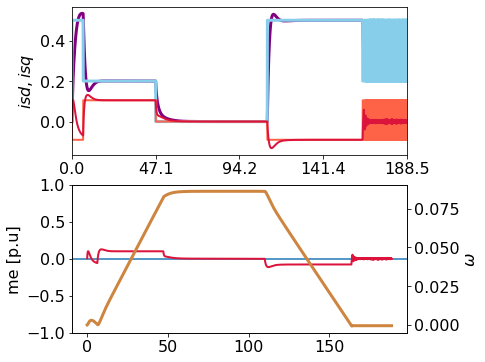

In [17]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

# V/f control 

In [199]:
deadZoneOmega = 0.02
volSpeedRatio = 0.5
def speedVoltageRelationship(w):
#     if w < deadZoneOmega:
#         return 0
    return (volSpeedRatio*w)

In [206]:
def simulateSpeedingUpWithAcceleration2():
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 20*3*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    # Initializing ws:
#     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    winput = np.zeros(len(Tta))
    us = np.zeros(len(Tta))
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle
    
    kp = 1.0e-8
    Ti = 1.0e-8
    Kparams = [kp, Ti]

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]
    flag = 0
    volAngle = 60

#     for ii in range(0, len(Tta))
    ii =0
    wref = 0.0
    wrefs = [wref]
#     isdref = 0.0
#     isqref = 0.0
#     isdrefs = [isdref]
#     isqrefs = [isqref]
    endOfStablization = 0
    while(ii < len(Tta)):      
        #Start controller after first step
        if ii>=0:
#             eid[ii] = wref - w[ii-1]
            
#             PIed = [eid[ii],eid[ii-1]]
            eid[ii] = wref - w[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            print("PIed:")
            print(PIed)
            winput[ii] = PIcon(PIed,  winput[ii-1], delta_t,Kparams)
            print("winput[ii]:")
            print(winput[ii])
            us[ii] = speedVoltageRelationship(winput[ii])
            print("us[ii]:")
            print(us[ii])            
#             us[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparams)
            usd[ii] = 1/2*us[ii]*np.cos(volAngle)
            usq[ii] = 1/2*us[ii]*np.sin(volAngle)
            print("usd, usq")
            print(usd[ii], usq[ii])
#             usd[ii] = us[ii]*np.cos(FCangle[ii])
#             usq[ii] = us[ii]*np.sin(FCangle[ii])
#             eiq[ii] = isqref - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
        if(w[ii] > 1):
            w[ii] = 1
        if(ii < len(Tta) and Tta[ii] >= 2*np.pi and Tta[ii] < 15*np.pi):
            print("Speeding up from:")
            print(Tta[ii])
            wref = 0.5
            wrefs.append(wref)
#             isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
        elif(ii < len(Tta) and Tta[ii] >= 15*np.pi and Tta[ii] < 35*np.pi):
            print("Uniform speed from:")
            print(Tta[ii])
            wref = 0.75
            wrefs.append(wref)
#             isdref = 0
#             isqref = 0
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
        else:
            print("Before Braking: w:")
            print(w[ii])
            print(Tta[ii])
            wref = 0
            wrefs.append(wref)
#             isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
        ii += 1
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w, me, isd, isq, np.array(wrefs)[0:len(Tta)]
#     return Tta, w, me, isd, isq, np.array(isdrefs)[0:len(Tta)], np.array(isqrefs)[0:len(Tta)]

In [207]:
def plotDynamicForSpeedingUp2(Tta, w1, me1, isd1, isq1, wrefs):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the speed and torque:
    pl.subplot(2,1,1)
#     pl.plot(Tta,  wrefs, 'pureple', lw=2)
#     pl.plot(Tta,  w1, 'pureple', lw=2)
    pl.plot(Tta,  wrefs, 'purple', lw=2)
    pl.plot(Tta,  w1, 'skyblue', lw=2)
    
#     pl.plot(Tta,  isd, 'purple', Tta, isq,'skyblue', lw=3)
#     pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)

#     pl.xlim(0,Tta[-1])
#     pl.ylabel(r'$\omega*, \omega$' )
#     pl.xticks(np.linspace(0,Tta[-1],5))

#     ax1 = pl.subplot(2,1,2)
#     ax1.axhline(0)
#     ax1.plot(Tta, me1, 'crimson', lw =2)
#     ax1.set_yticks(np.linspace(-1.0,1.0,5))
#     ax1.set_ylabel('me [p.u]')
#     ax2 = ax1.twinx()
#     ax2.set_ylabel('$\omega$')
#     ax2.plot(Tta,w1, 'peru', lw =3)

PIed:
[0.0, 0.0]
winput[ii]:
0.0
us[ii]:
0.0
usd, usq
-0.0 -0.0
Before Braking: w:
1.2831457301089506e-06
0.0
PIed:
[-1.2831457301089506e-06, 0.0]
winput[ii]:
-1.283145742940408e-06
us[ii]:
6.41572871470204e-07
usd, usq
-3.055211653352235e-07 -9.777911271758276e-08
Before Braking: w:
3.839259485042775e-06
0.01
PIed:
[-3.839259485042775e-06, -1.2831457301089506e-06]
winput[ii]:
-5.122405253544321e-06
us[ii]:
2.5612026267721605e-06
usd, usq
-1.2196613136056003e-06 -3.9034088171752553e-07
Before Braking: w:
7.65833836092588e-06
0.02
PIed:
[-7.65833836092588e-06, -3.839259485042775e-06]
winput[ii]:
-1.2780743652660989e-05
us[ii]:
6.390371826330494e-06
usd, usq
-3.043136538538236e-06 -9.739266027289524e-07
Before Braking: w:
1.2730551475917742e-05
0.03
PIed:
[-1.2730551475917742e-05, -7.65833836092588e-06]
winput[ii]:
-2.5511295179300863e-05
us[ii]:
1.2755647589650432e-05
usd, usq
-6.074322168992186e-06 -1.9440284321811708e-06
Before Braking: w:
1.904623308455187e-05
0.04
PIed:
[-1.90462330

1.94
PIed:
[-0.018208494268555205, -0.018032424217220233]
winput[ii]:
-1.2527087403150383
us[ii]:
0.6263543701575192
usd, usq
-0.29827401623889044 -0.09545973229890058
Before Braking: w:
0.01838552496150122
1.95
PIed:
[-0.01838552496150122, -0.018208494268555205]
winput[ii]:
-1.27109426527831
us[ii]:
0.635547132639155
usd, usq
-0.30265166939558213 -0.09686075811973685
Before Braking: w:
0.018563521466741936
1.96
PIed:
[-0.018563521466741936, -0.01838552496150122]
winput[ii]:
-1.2896577867468317
us[ii]:
0.6448288933734159
usd, usq
-0.307071704097791 -0.09827534774690297
Before Braking: w:
0.01874248904530279
1.97
PIed:
[-0.01874248904530279, -0.018563521466741936]
winput[ii]:
-1.3084002757939242
us[ii]:
0.6542001378969621
usd, usq
-0.31153435156122594 -0.09970357517876441
Before Braking: w:
0.01892243304935088
1.98
PIed:
[-0.01892243304935088, -0.01874248904530279]
winput[ii]:
-1.3273227088450745
us[ii]:
0.6636613544225373
usd, usq
-0.31603984427596404 -0.10114551482153597
Before Brakin

Before Braking: w:
0.07766412965853262
3.7600000000000002
PIed:
[-0.07766412965853262, -0.0770737849322903]
winput[ii]:
-8.929813394260968
us[ii]:
4.464906697130484
usd, usq
-2.126217547344818 -0.6804754917578949
Before Braking: w:
0.0782595830455795
3.77
PIed:
[-0.0782595830455795, -0.07766412965853262]
winput[ii]:
-9.008072977312501
us[ii]:
4.504036488656251
usd, usq
-2.1448514080298575 -0.6864390797871794
Before Braking: w:
0.07886020440767741
3.7800000000000002
PIed:
[-0.07886020440767741, -0.0782595830455795]
winput[ii]:
-9.086933181726184
us[ii]:
4.543466590863092
usd, usq
-2.163628278610304 -0.6924484367590751
Before Braking: w:
0.07946605383388225
3.79
PIed:
[-0.07946605383388225, -0.07886020440767741]
winput[ii]:
-9.166399235566125
us[ii]:
4.5831996177830625
usd, usq
-2.182549403905186 -0.6985039610659487
Before Braking: w:
0.0800771921987414
3.8000000000000003
PIed:
[-0.0800771921987414, -0.07946605383388225]
winput[ii]:
-9.246476427770977
us[ii]:
4.623238213885489
usd, usq
-

Speeding up from:
7.0
PIed:
[-0.5, -0.5]
winput[ii]:
-120.66636740093293
us[ii]:
60.33318370046646
usd, usq
-28.731053653048196 -9.19509759840666
Speeding up from:
7.01
PIed:
[-0.5, -0.5]
winput[ii]:
-121.16636740093293
us[ii]:
60.58318370046646
usd, usq
-28.850105275600093 -9.233198926044436
Speeding up from:
7.0200000000000005
PIed:
[-0.5, -0.5]
winput[ii]:
-121.66636740093293
us[ii]:
60.83318370046646
usd, usq
-28.969156898151986 -9.271300253682213
Speeding up from:
7.03
PIed:
[-0.5, -0.5]
winput[ii]:
-122.16636740093293
us[ii]:
61.08318370046646
usd, usq
-29.08820852070388 -9.30940158131999
Speeding up from:
7.04
PIed:
[-0.5, -0.5]
winput[ii]:
-122.66636740093293
us[ii]:
61.33318370046646
usd, usq
-29.207260143255777 -9.347502908957768
Speeding up from:
7.05
PIed:
[-0.5, -0.5]
winput[ii]:
-123.16636740093293
us[ii]:
61.58318370046646
usd, usq
-29.32631176580767 -9.385604236595544
Speeding up from:
7.0600000000000005
PIed:
[-0.5, -0.5]
winput[ii]:
-123.66636740093293
us[ii]:
61.8331

Speeding up from:
11.25
PIed:
[-0.5, -0.5]
winput[ii]:
-333.1663674009329
us[ii]:
166.58318370046646
usd, usq
-79.32799323760338 -25.38816184446192
Speeding up from:
11.26
PIed:
[-0.5, -0.5]
winput[ii]:
-333.6663674009329
us[ii]:
166.83318370046646
usd, usq
-79.44704486015527 -25.4262631720997
Speeding up from:
11.27
PIed:
[-0.5, -0.5]
winput[ii]:
-334.1663674009329
us[ii]:
167.08318370046646
usd, usq
-79.56609648270717 -25.464364499737474
Speeding up from:
11.28
PIed:
[-0.5, -0.5]
winput[ii]:
-334.6663674009329
us[ii]:
167.33318370046646
usd, usq
-79.68514810525906 -25.502465827375254
Speeding up from:
11.290000000000001
PIed:
[-0.5, -0.5]
winput[ii]:
-335.1663674009329
us[ii]:
167.58318370046646
usd, usq
-79.80419972781095 -25.54056715501303
Speeding up from:
11.3
PIed:
[-0.5, -0.5]
winput[ii]:
-335.6663674009329
us[ii]:
167.83318370046646
usd, usq
-79.92325135036285 -25.578668482650805
Speeding up from:
11.31
PIed:
[-0.5, -0.5]
winput[ii]:
-336.1663674009329
us[ii]:
168.083183700466

[-0.5, -0.5]
winput[ii]:
-471.1663674009329
us[ii]:
235.58318370046646
usd, usq
-112.18624106192627 -35.90412827248839
Speeding up from:
14.02
PIed:
[-0.5, -0.5]
winput[ii]:
-471.6663674009329
us[ii]:
235.83318370046646
usd, usq
-112.30529268447816 -35.942229600126176
Speeding up from:
14.030000000000001
PIed:
[-0.5, -0.5]
winput[ii]:
-472.1663674009329
us[ii]:
236.08318370046646
usd, usq
-112.42434430703005 -35.98033092776395
Speeding up from:
14.040000000000001
PIed:
[-0.5, -0.5]
winput[ii]:
-472.6663674009329
us[ii]:
236.33318370046646
usd, usq
-112.54339592958195 -36.01843225540173
Speeding up from:
14.05
PIed:
[-0.5, -0.5]
winput[ii]:
-473.1663674009329
us[ii]:
236.58318370046646
usd, usq
-112.66244755213384 -36.0565335830395
Speeding up from:
14.06
PIed:
[-0.5, -0.5]
winput[ii]:
-473.6663674009329
us[ii]:
236.83318370046646
usd, usq
-112.78149917468575 -36.09463491067728
Speeding up from:
14.07
PIed:
[-0.5, -0.5]
winput[ii]:
-474.1663674009329
us[ii]:
237.08318370046646
usd, usq


[-0.5, -0.5]
winput[ii]:
-567.6663674009329
us[ii]:
283.83318370046646
usd, usq
-135.16320421444192 -43.25768450657937
Speeding up from:
15.950000000000001
PIed:
[-0.5, -0.5]
winput[ii]:
-568.1663674009329
us[ii]:
284.08318370046646
usd, usq
-135.2822558369938 -43.29578583421715
Speeding up from:
15.96
PIed:
[-0.5, -0.5]
winput[ii]:
-568.6663674009329
us[ii]:
284.33318370046646
usd, usq
-135.4013074595457 -43.333887161854925
Speeding up from:
15.97
PIed:
[-0.5, -0.5]
winput[ii]:
-569.1663674009329
us[ii]:
284.58318370046646
usd, usq
-135.5203590820976 -43.37198848949271
Speeding up from:
15.98
PIed:
[-0.5, -0.5]
winput[ii]:
-569.6663674009329
us[ii]:
284.83318370046646
usd, usq
-135.6394107046495 -43.41008981713048
Speeding up from:
15.99
PIed:
[-0.5, -0.5]
winput[ii]:
-570.1663674009329
us[ii]:
285.08318370046646
usd, usq
-135.75846232720139 -43.44819114476826
Speeding up from:
16.0
PIed:
[-0.5, -0.5]
winput[ii]:
-570.6663674009329
us[ii]:
285.33318370046646
usd, usq
-135.877513949753

PIed:
[-0.5, -0.5]
winput[ii]:
-655.6663674009329
us[ii]:
327.83318370046646
usd, usq
-156.11628978357535 -49.96351817082814
Speeding up from:
17.71
PIed:
[-0.5, -0.5]
winput[ii]:
-656.1663674009329
us[ii]:
328.08318370046646
usd, usq
-156.23534140612725 -50.00161949846592
Speeding up from:
17.72
PIed:
[-0.5, -0.5]
winput[ii]:
-656.6663674009329
us[ii]:
328.33318370046646
usd, usq
-156.35439302867914 -50.0397208261037
Speeding up from:
17.73
PIed:
[-0.5, -0.5]
winput[ii]:
-657.1663674009329
us[ii]:
328.58318370046646
usd, usq
-156.47344465123103 -50.07782215374147
Speeding up from:
17.740000000000002
PIed:
[-0.5, -0.5]
winput[ii]:
-657.6663674009329
us[ii]:
328.83318370046646
usd, usq
-156.59249627378293 -50.11592348137925
Speeding up from:
17.75
PIed:
[-0.5, -0.5]
winput[ii]:
-658.1663674009329
us[ii]:
329.08318370046646
usd, usq
-156.71154789633482 -50.154024809017024
Speeding up from:
17.76
PIed:
[-0.5, -0.5]
winput[ii]:
-658.6663674009329
us[ii]:
329.33318370046646
usd, usq
-156.83

21.91
PIed:
[-0.5, -0.5]
winput[ii]:
-866.1663674009329
us[ii]:
433.08318370046646
usd, usq
-206.23702287792295 -66.00417710633229
Speeding up from:
21.92
PIed:
[-0.5, -0.5]
winput[ii]:
-866.6663674009329
us[ii]:
433.33318370046646
usd, usq
-206.35607450047485 -66.04227843397007
Speeding up from:
21.93
PIed:
[-0.5, -0.5]
winput[ii]:
-867.1663674009329
us[ii]:
433.58318370046646
usd, usq
-206.47512612302674 -66.08037976160784
Speeding up from:
21.94
PIed:
[-0.5, -0.5]
winput[ii]:
-867.6663674009329
us[ii]:
433.83318370046646
usd, usq
-206.59417774557863 -66.11848108924562
Speeding up from:
21.95
PIed:
[-0.5, -0.5]
winput[ii]:
-868.1663674009329
us[ii]:
434.08318370046646
usd, usq
-206.71322936813053 -66.1565824168834
Speeding up from:
21.96
PIed:
[-0.5, -0.5]
winput[ii]:
-868.6663674009329
us[ii]:
434.33318370046646
usd, usq
-206.83228099068242 -66.19468374452119
Speeding up from:
21.97
PIed:
[-0.5, -0.5]
winput[ii]:
-869.1663674009329
us[ii]:
434.58318370046646
usd, usq
-206.9513326132

PIed:
[-0.5, -0.5]
winput[ii]:
-1076.1663674009328
us[ii]:
538.0831837004664
usd, usq
-256.23870434971866 -82.00673471419866
Speeding up from:
26.12
PIed:
[-0.5, -0.5]
winput[ii]:
-1076.6663674009328
us[ii]:
538.3331837004664
usd, usq
-256.3577559722705 -82.04483604183643
Speeding up from:
26.13
PIed:
[-0.5, -0.5]
winput[ii]:
-1077.1663674009328
us[ii]:
538.5831837004664
usd, usq
-256.47680759482245 -82.08293736947421
Speeding up from:
26.14
PIed:
[-0.5, -0.5]
winput[ii]:
-1077.6663674009328
us[ii]:
538.8331837004664
usd, usq
-256.5958592173743 -82.121038697112
Speeding up from:
26.150000000000002
PIed:
[-0.5, -0.5]
winput[ii]:
-1078.1663674009328
us[ii]:
539.0831837004664
usd, usq
-256.71491083992623 -82.15914002474977
Speeding up from:
26.16
PIed:
[-0.5, -0.5]
winput[ii]:
-1078.6663674009328
us[ii]:
539.3331837004664
usd, usq
-256.8339624624781 -82.19724135238755
Speeding up from:
26.17
PIed:
[-0.5, -0.5]
winput[ii]:
-1079.1663674009328
us[ii]:
539.5831837004664
usd, usq
-256.9530140

Speeding up from:
28.09
PIed:
[-0.5, -0.5]
winput[ii]:
-1175.1663674009328
us[ii]:
587.5831837004664
usd, usq
-279.8109256149938 -89.55079758647852
Speeding up from:
28.1
PIed:
[-0.5, -0.5]
winput[ii]:
-1175.6663674009328
us[ii]:
587.8331837004664
usd, usq
-279.92997723754564 -89.5888989141163
Speeding up from:
28.11
PIed:
[-0.5, -0.5]
winput[ii]:
-1176.1663674009328
us[ii]:
588.0831837004664
usd, usq
-280.04902886009756 -89.62700024175408
Speeding up from:
28.12
PIed:
[-0.5, -0.5]
winput[ii]:
-1176.6663674009328
us[ii]:
588.3331837004664
usd, usq
-280.16808048264943 -89.66510156939185
Speeding up from:
28.13
PIed:
[-0.5, -0.5]
winput[ii]:
-1177.1663674009328
us[ii]:
588.5831837004664
usd, usq
-280.28713210520135 -89.70320289702963
Speeding up from:
28.14
PIed:
[-0.5, -0.5]
winput[ii]:
-1177.6663674009328
us[ii]:
588.8331837004664
usd, usq
-280.4061837277532 -89.7413042246674
Speeding up from:
28.150000000000002
PIed:
[-0.5, -0.5]
winput[ii]:
-1178.1663674009328
us[ii]:
589.08318370046

-315.05020589035456 -100.82879056726054
Speeding up from:
31.060000000000002
PIed:
[-0.5, -0.5]
winput[ii]:
-1323.6663674009328
us[ii]:
661.8331837004664
usd, usq
-315.1692575129064 -100.86689189489832
Speeding up from:
31.07
PIed:
[-0.5, -0.5]
winput[ii]:
-1324.1663674009328
us[ii]:
662.0831837004664
usd, usq
-315.28830913545835 -100.90499322253609
Speeding up from:
31.080000000000002
PIed:
[-0.5, -0.5]
winput[ii]:
-1324.6663674009328
us[ii]:
662.3331837004664
usd, usq
-315.4073607580102 -100.94309455017387
Speeding up from:
31.09
PIed:
[-0.5, -0.5]
winput[ii]:
-1325.1663674009328
us[ii]:
662.5831837004664
usd, usq
-315.52641238056214 -100.98119587781164
Speeding up from:
31.1
PIed:
[-0.5, -0.5]
winput[ii]:
-1325.6663674009328
us[ii]:
662.8331837004664
usd, usq
-315.645464003114 -101.01929720544943
Speeding up from:
31.11
PIed:
[-0.5, -0.5]
winput[ii]:
-1326.1663674009328
us[ii]:
663.0831837004664
usd, usq
-315.7645156256659 -101.05739853308721
Speeding up from:
31.12
PIed:
[-0.5, -0.

-340.0510466262524 -108.83006937119373
Speeding up from:
33.160000000000004
PIed:
[-0.5, -0.5]
winput[ii]:
-1428.6663674009328
us[ii]:
714.3331837004664
usd, usq
-340.17009824880427 -108.8681706988315
Speeding up from:
33.17
PIed:
[-0.5, -0.5]
winput[ii]:
-1429.1663674009328
us[ii]:
714.5831837004664
usd, usq
-340.2891498713562 -108.90627202646928
Speeding up from:
33.18
PIed:
[-0.5, -0.5]
winput[ii]:
-1429.6663674009328
us[ii]:
714.8331837004664
usd, usq
-340.40820149390805 -108.94437335410706
Speeding up from:
33.19
PIed:
[-0.5, -0.5]
winput[ii]:
-1430.1663674009328
us[ii]:
715.0831837004664
usd, usq
-340.52725311646 -108.98247468174483
Speeding up from:
33.2
PIed:
[-0.5, -0.5]
winput[ii]:
-1430.6663674009328
us[ii]:
715.3331837004664
usd, usq
-340.64630473901184 -109.02057600938261
Speeding up from:
33.21
PIed:
[-0.5, -0.5]
winput[ii]:
-1431.1663674009328
us[ii]:
715.5831837004664
usd, usq
-340.76535636156376 -109.0586773370204
Speeding up from:
33.22
PIed:
[-0.5, -0.5]
winput[ii]:


-376.24273988202833 -120.41287297307797
Speeding up from:
36.2
PIed:
[-0.5, -0.5]
winput[ii]:
-1580.6663674009328
us[ii]:
790.3331837004664
usd, usq
-376.36179150458025 -120.45097430071574
Speeding up from:
36.21
PIed:
[-0.5, -0.5]
winput[ii]:
-1581.1663674009328
us[ii]:
790.5831837004664
usd, usq
-376.4808431271321 -120.48907562835352
Speeding up from:
36.22
PIed:
[-0.5, -0.5]
winput[ii]:
-1581.6663674009328
us[ii]:
790.8331837004664
usd, usq
-376.59989474968404 -120.5271769559913
Speeding up from:
36.230000000000004
PIed:
[-0.5, -0.5]
winput[ii]:
-1582.1663674009328
us[ii]:
791.0831837004664
usd, usq
-376.7189463722359 -120.56527828362907
Speeding up from:
36.24
PIed:
[-0.5, -0.5]
winput[ii]:
-1582.6663674009328
us[ii]:
791.3331837004664
usd, usq
-376.8379979947878 -120.60337961126685
Speeding up from:
36.25
PIed:
[-0.5, -0.5]
winput[ii]:
-1583.1663674009328
us[ii]:
791.5831837004664
usd, usq
-376.9570496173397 -120.64148093890462
Speeding up from:
36.26
PIed:
[-0.5, -0.5]
winput[ii]

40.44
PIed:
[-0.5, -0.5]
winput[ii]:
-1792.6663674009328
us[ii]:
896.3331837004664
usd, usq
-426.8396794665835 -136.6059372191332
Speeding up from:
40.45
PIed:
[-0.5, -0.5]
winput[ii]:
-1793.1663674009328
us[ii]:
896.5831837004664
usd, usq
-426.9587310891354 -136.64403854677101
Speeding up from:
40.46
PIed:
[-0.5, -0.5]
winput[ii]:
-1793.6663674009328
us[ii]:
896.8331837004664
usd, usq
-427.0777827116873 -136.6821398744088
Speeding up from:
40.47
PIed:
[-0.5, -0.5]
winput[ii]:
-1794.1663674009328
us[ii]:
897.0831837004664
usd, usq
-427.1968343342392 -136.72024120204657
Speeding up from:
40.480000000000004
PIed:
[-0.5, -0.5]
winput[ii]:
-1794.6663674009328
us[ii]:
897.3331837004664
usd, usq
-427.3158859567911 -136.75834252968434
Speeding up from:
40.49
PIed:
[-0.5, -0.5]
winput[ii]:
-1795.1663674009328
us[ii]:
897.5831837004664
usd, usq
-427.434937579343 -136.79644385732212
Speeding up from:
40.5
PIed:
[-0.5, -0.5]
winput[ii]:
-1795.6663674009328
us[ii]:
897.8331837004664
usd, usq
-427.

-1973.1663674009328
us[ii]:
986.5831837004664
usd, usq
-469.81731520781744 -150.36051649637076
Speeding up from:
44.06
PIed:
[-0.5, -0.5]
winput[ii]:
-1973.6663674009328
us[ii]:
986.8331837004664
usd, usq
-469.9363668303693 -150.39861782400854
Speeding up from:
44.07
PIed:
[-0.5, -0.5]
winput[ii]:
-1974.1663674009328
us[ii]:
987.0831837004664
usd, usq
-470.05541845292123 -150.43671915164632
Speeding up from:
44.08
PIed:
[-0.5, -0.5]
winput[ii]:
-1974.6663674009328
us[ii]:
987.3331837004664
usd, usq
-470.1744700754731 -150.4748204792841
Speeding up from:
44.09
PIed:
[-0.5, -0.5]
winput[ii]:
-1975.1663674009328
us[ii]:
987.5831837004664
usd, usq
-470.293521698025 -150.51292180692187
Speeding up from:
44.1
PIed:
[-0.5, -0.5]
winput[ii]:
-1975.6663674009328
us[ii]:
987.8331837004664
usd, usq
-470.41257332057694 -150.55102313455964
Speeding up from:
44.11
PIed:
[-0.5, -0.5]
winput[ii]:
-1976.1663674009328
us[ii]:
988.0831837004664
usd, usq
-470.5316249431288 -150.58912446219742
Speeding up 

1070.4581836992163
usd, usq
-509.75913457338277 -163.14351191865444
Uniform speed from:
47.7
PIed:
[-0.25, -0.25]
winput[ii]:
-2141.1663673984326
us[ii]:
1070.5831836992163
usd, usq
-509.8186603846587 -163.16256258247333
Uniform speed from:
47.71
PIed:
[-0.25, -0.25]
winput[ii]:
-2141.4163673984326
us[ii]:
1070.7081836992163
usd, usq
-509.87818619593463 -163.18161324629222
Uniform speed from:
47.72
PIed:
[-0.25, -0.25]
winput[ii]:
-2141.6663673984326
us[ii]:
1070.8331836992163
usd, usq
-509.9377120072106 -163.2006639101111
Uniform speed from:
47.730000000000004
PIed:
[-0.25, -0.25]
winput[ii]:
-2141.9163673984326
us[ii]:
1070.9581836992163
usd, usq
-509.99723781848655 -163.21971457393
Uniform speed from:
47.74
PIed:
[-0.25, -0.25]
winput[ii]:
-2142.1663673984326
us[ii]:
1071.0831836992163
usd, usq
-510.0567636297625 -163.23876523774888
Uniform speed from:
47.75
PIed:
[-0.25, -0.25]
winput[ii]:
-2142.4163673984326
us[ii]:
1071.2081836992163
usd, usq
-510.1162894410384 -163.2578159015677

Uniform speed from:
51.410000000000004
PIed:
[-0.25, -0.25]
winput[ii]:
-2233.9163673984326
us[ii]:
1116.9581836992163
usd, usq
-531.9027363680351 -170.23035885928098
Uniform speed from:
51.42
PIed:
[-0.25, -0.25]
winput[ii]:
-2234.1663673984326
us[ii]:
1117.0831836992163
usd, usq
-531.9622621793111 -170.24940952309987
Uniform speed from:
51.43
PIed:
[-0.25, -0.25]
winput[ii]:
-2234.4163673984326
us[ii]:
1117.2081836992163
usd, usq
-532.0217879905871 -170.26846018691876
Uniform speed from:
51.44
PIed:
[-0.25, -0.25]
winput[ii]:
-2234.6663673984326
us[ii]:
1117.3331836992163
usd, usq
-532.081313801863 -170.28751085073765
Uniform speed from:
51.45
PIed:
[-0.25, -0.25]
winput[ii]:
-2234.9163673984326
us[ii]:
1117.4581836992163
usd, usq
-532.140839613139 -170.30656151455653
Uniform speed from:
51.46
PIed:
[-0.25, -0.25]
winput[ii]:
-2235.1663673984326
us[ii]:
1117.5831836992163
usd, usq
-532.2003654244148 -170.32561217837542
Uniform speed from:
51.47
PIed:
[-0.25, -0.25]
winput[ii]:
-2235.

us[ii]:
1147.2081836992163
usd, usq
-546.3079826968144 -174.84061950345202
Uniform speed from:
53.84
PIed:
[-0.25, -0.25]
winput[ii]:
-2294.6663673984326
us[ii]:
1147.3331836992163
usd, usq
-546.3675085080903 -174.8596701672709
Uniform speed from:
53.85
PIed:
[-0.25, -0.25]
winput[ii]:
-2294.9163673984326
us[ii]:
1147.4581836992163
usd, usq
-546.4270343193663 -174.8787208310898
Uniform speed from:
53.86
PIed:
[-0.25, -0.25]
winput[ii]:
-2295.1663673984326
us[ii]:
1147.5831836992163
usd, usq
-546.4865601306423 -174.89777149490868
Uniform speed from:
53.870000000000005
PIed:
[-0.25, -0.25]
winput[ii]:
-2295.4163673984326
us[ii]:
1147.7081836992163
usd, usq
-546.5460859419181 -174.91682215872757
Uniform speed from:
53.88
PIed:
[-0.25, -0.25]
winput[ii]:
-2295.6663673984326
us[ii]:
1147.8331836992163
usd, usq
-546.6056117531941 -174.93587282254646
Uniform speed from:
53.89
PIed:
[-0.25, -0.25]
winput[ii]:
-2295.9163673984326
us[ii]:
1147.9581836992163
usd, usq
-546.6651375644701 -174.95492

Uniform speed from:
58.28
PIed:
[-0.25, -0.25]
winput[ii]:
-2405.6663673984326
us[ii]:
1202.8331836992163
usd, usq
-572.7969687146109 -183.3181649028574
Uniform speed from:
58.29
PIed:
[-0.25, -0.25]
winput[ii]:
-2405.9163673984326
us[ii]:
1202.9581836992163
usd, usq
-572.8564945258869 -183.3372155666763
Uniform speed from:
58.300000000000004
PIed:
[-0.25, -0.25]
winput[ii]:
-2406.1663673984326
us[ii]:
1203.0831836992163
usd, usq
-572.9160203371628 -183.35626623049518
Uniform speed from:
58.31
PIed:
[-0.25, -0.25]
winput[ii]:
-2406.4163673984326
us[ii]:
1203.2081836992163
usd, usq
-572.9755461484388 -183.37531689431407
Uniform speed from:
58.32
PIed:
[-0.25, -0.25]
winput[ii]:
-2406.6663673984326
us[ii]:
1203.3331836992163
usd, usq
-573.0350719597147 -183.39436755813296
Uniform speed from:
58.33
PIed:
[-0.25, -0.25]
winput[ii]:
-2406.9163673984326
us[ii]:
1203.4581836992163
usd, usq
-573.0945977709906 -183.41341822195184
Uniform speed from:
58.34
PIed:
[-0.25, -0.25]
winput[ii]:
-2407.

Uniform speed from:
60.65
PIed:
[-0.25, -0.25]
winput[ii]:
-2464.9163673984326
us[ii]:
1232.4581836992163
usd, usq
-586.9045859870104 -187.833172227934
Uniform speed from:
60.660000000000004
PIed:
[-0.25, -0.25]
winput[ii]:
-2465.1663673984326
us[ii]:
1232.5831836992163
usd, usq
-586.9641117982864 -187.8522228917529
Uniform speed from:
60.67
PIed:
[-0.25, -0.25]
winput[ii]:
-2465.4163673984326
us[ii]:
1232.7081836992163
usd, usq
-587.0236376095623 -187.87127355557178
Uniform speed from:
60.68
PIed:
[-0.25, -0.25]
winput[ii]:
-2465.6663673984326
us[ii]:
1232.8331836992163
usd, usq
-587.0831634208382 -187.89032421939066
Uniform speed from:
60.69
PIed:
[-0.25, -0.25]
winput[ii]:
-2465.9163673984326
us[ii]:
1232.9581836992163
usd, usq
-587.1426892321142 -187.90937488320955
Uniform speed from:
60.7
PIed:
[-0.25, -0.25]
winput[ii]:
-2466.1663673984326
us[ii]:
1233.0831836992163
usd, usq
-587.2022150433902 -187.92842554702844
Uniform speed from:
60.71
PIed:
[-0.25, -0.25]
winput[ii]:
-2466.41

1280.4581836992163
usd, usq
-609.7624975169741 -195.1486271343872
Uniform speed from:
64.5
PIed:
[-0.25, -0.25]
winput[ii]:
-2561.1663673984326
us[ii]:
1280.5831836992163
usd, usq
-609.8220233282501 -195.16767779820609
Uniform speed from:
64.51
PIed:
[-0.25, -0.25]
winput[ii]:
-2561.4163673984326
us[ii]:
1280.7081836992163
usd, usq
-609.8815491395261 -195.18672846202497
Uniform speed from:
64.52
PIed:
[-0.25, -0.25]
winput[ii]:
-2561.6663673984326
us[ii]:
1280.8331836992163
usd, usq
-609.941074950802 -195.20577912584386
Uniform speed from:
64.53
PIed:
[-0.25, -0.25]
winput[ii]:
-2561.9163673984326
us[ii]:
1280.9581836992163
usd, usq
-610.000600762078 -195.22482978966275
Uniform speed from:
64.54
PIed:
[-0.25, -0.25]
winput[ii]:
-2562.1663673984326
us[ii]:
1281.0831836992163
usd, usq
-610.060126573354 -195.24388045348164
Uniform speed from:
64.55
PIed:
[-0.25, -0.25]
winput[ii]:
-2562.4163673984326
us[ii]:
1281.2081836992163
usd, usq
-610.1196523846298 -195.26293111730052
Uniform speed 

us[ii]:
1322.2081836992163
usd, usq
-629.6441184831406 -201.51154884989597
Uniform speed from:
67.84
PIed:
[-0.25, -0.25]
winput[ii]:
-2644.6663673984326
us[ii]:
1322.3331836992163
usd, usq
-629.7036442944164 -201.53059951371486
Uniform speed from:
67.85
PIed:
[-0.25, -0.25]
winput[ii]:
-2644.9163673984326
us[ii]:
1322.4581836992163
usd, usq
-629.7631701056924 -201.54965017753375
Uniform speed from:
67.86
PIed:
[-0.25, -0.25]
winput[ii]:
-2645.1663673984326
us[ii]:
1322.5831836992163
usd, usq
-629.8226959169684 -201.56870084135264
Uniform speed from:
67.87
PIed:
[-0.25, -0.25]
winput[ii]:
-2645.4163673984326
us[ii]:
1322.7081836992163
usd, usq
-629.8822217282443 -201.58775150517152
Uniform speed from:
67.88
PIed:
[-0.25, -0.25]
winput[ii]:
-2645.6663673984326
us[ii]:
1322.8331836992163
usd, usq
-629.9417475395203 -201.6068021689904
Uniform speed from:
67.89
PIed:
[-0.25, -0.25]
winput[ii]:
-2645.9163673984326
us[ii]:
1322.9581836992163
usd, usq
-630.0012733507963 -201.6258528328093
Uni

winput[ii]:
-2682.4163673984326
us[ii]:
1341.2081836992163
usd, usq
-638.6920417970846 -204.40724975036701
Uniform speed from:
69.36
PIed:
[-0.25, -0.25]
winput[ii]:
-2682.6663673984326
us[ii]:
1341.3331836992163
usd, usq
-638.7515676083605 -204.4263004141859
Uniform speed from:
69.37
PIed:
[-0.25, -0.25]
winput[ii]:
-2682.9163673984326
us[ii]:
1341.4581836992163
usd, usq
-638.8110934196364 -204.4453510780048
Uniform speed from:
69.38
PIed:
[-0.25, -0.25]
winput[ii]:
-2683.1663673984326
us[ii]:
1341.5831836992163
usd, usq
-638.8706192309123 -204.46440174182368
Uniform speed from:
69.39
PIed:
[-0.25, -0.25]
winput[ii]:
-2683.4163673984326
us[ii]:
1341.7081836992163
usd, usq
-638.9301450421883 -204.48345240564257
Uniform speed from:
69.4
PIed:
[-0.25, -0.25]
winput[ii]:
-2683.6663673984326
us[ii]:
1341.8331836992163
usd, usq
-638.9896708534643 -204.50250306946148
Uniform speed from:
69.41
PIed:
[-0.25, -0.25]
winput[ii]:
-2683.9163673984326
us[ii]:
1341.9581836992163
usd, usq
-639.049196

1370.0831836992163
usd, usq
-652.4425042018283 -208.80795309253028
Uniform speed from:
71.67
PIed:
[-0.25, -0.25]
winput[ii]:
-2740.4163673984326
us[ii]:
1370.2081836992163
usd, usq
-652.5020300131043 -208.82700375634917
Uniform speed from:
71.68
PIed:
[-0.25, -0.25]
winput[ii]:
-2740.6663673984326
us[ii]:
1370.3331836992163
usd, usq
-652.5615558243802 -208.84605442016806
Uniform speed from:
71.69
PIed:
[-0.25, -0.25]
winput[ii]:
-2740.9163673984326
us[ii]:
1370.4581836992163
usd, usq
-652.6210816356562 -208.86510508398695
Uniform speed from:
71.7
PIed:
[-0.25, -0.25]
winput[ii]:
-2741.1663673984326
us[ii]:
1370.5831836992163
usd, usq
-652.6806074469322 -208.88415574780583
Uniform speed from:
71.71000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-2741.4163673984326
us[ii]:
1370.7081836992163
usd, usq
-652.7401332582081 -208.90320641162472
Uniform speed from:
71.72
PIed:
[-0.25, -0.25]
winput[ii]:
-2741.6663673984326
us[ii]:
1370.8331836992163
usd, usq
-652.799659069484 -208.9222570754436


[-0.25, -0.25]
winput[ii]:
-2843.1663673984326
us[ii]:
1421.5831836992163
usd, usq
-676.9671384475187 -216.65682658591237
Uniform speed from:
75.79
PIed:
[-0.25, -0.25]
winput[ii]:
-2843.4163673984326
us[ii]:
1421.7081836992163
usd, usq
-677.0266642587945 -216.67587724973126
Uniform speed from:
75.8
PIed:
[-0.25, -0.25]
winput[ii]:
-2843.6663673984326
us[ii]:
1421.8331836992163
usd, usq
-677.0861900700705 -216.69492791355015
Uniform speed from:
75.81
PIed:
[-0.25, -0.25]
winput[ii]:
-2843.9163673984326
us[ii]:
1421.9581836992163
usd, usq
-677.1457158813465 -216.71397857736903
Uniform speed from:
75.82000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-2844.1663673984326
us[ii]:
1422.0831836992163
usd, usq
-677.2052416926224 -216.73302924118792
Uniform speed from:
75.83
PIed:
[-0.25, -0.25]
winput[ii]:
-2844.4163673984326
us[ii]:
1422.2081836992163
usd, usq
-677.2647675038984 -216.7520799050068
Uniform speed from:
75.84
PIed:
[-0.25, -0.25]
winput[ii]:
-2844.6663673984326
us[ii]:
1422.333183

-2949.1663673984326
us[ii]:
1474.5831836992163
usd, usq
-702.2060824285203 -224.7343080451211
Uniform speed from:
80.03
PIed:
[-0.25, -0.25]
winput[ii]:
-2949.4163673984326
us[ii]:
1474.7081836992163
usd, usq
-702.2656082397963 -224.75335870894
Uniform speed from:
80.04
PIed:
[-0.25, -0.25]
winput[ii]:
-2949.6663673984326
us[ii]:
1474.8331836992163
usd, usq
-702.3251340510722 -224.7724093727589
Uniform speed from:
80.05
PIed:
[-0.25, -0.25]
winput[ii]:
-2949.9163673984326
us[ii]:
1474.9581836992163
usd, usq
-702.3846598623481 -224.79146003657777
Uniform speed from:
80.06
PIed:
[-0.25, -0.25]
winput[ii]:
-2950.1663673984326
us[ii]:
1475.0831836992163
usd, usq
-702.444185673624 -224.81051070039666
Uniform speed from:
80.07000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-2950.4163673984326
us[ii]:
1475.2081836992163
usd, usq
-702.5037114849 -224.82956136421555
Uniform speed from:
80.08
PIed:
[-0.25, -0.25]
winput[ii]:
-2950.6663673984326
us[ii]:
1475.3331836992163
usd, usq
-702.563237296176

-3051.4163673984326
us[ii]:
1525.7081836992163
usd, usq
-726.5521392403828 -232.5260295470465
Uniform speed from:
84.12
PIed:
[-0.25, -0.25]
winput[ii]:
-3051.6663673984326
us[ii]:
1525.8331836992163
usd, usq
-726.6116650516586 -232.5450802108654
Uniform speed from:
84.13
PIed:
[-0.25, -0.25]
winput[ii]:
-3051.9163673984326
us[ii]:
1525.9581836992163
usd, usq
-726.6711908629346 -232.56413087468428
Uniform speed from:
84.14
PIed:
[-0.25, -0.25]
winput[ii]:
-3052.1663673984326
us[ii]:
1526.0831836992163
usd, usq
-726.7307166742105 -232.58318153850317
Uniform speed from:
84.15
PIed:
[-0.25, -0.25]
winput[ii]:
-3052.4163673984326
us[ii]:
1526.2081836992163
usd, usq
-726.7902424854865 -232.60223220232206
Uniform speed from:
84.16
PIed:
[-0.25, -0.25]
winput[ii]:
-3052.6663673984326
us[ii]:
1526.3331836992163
usd, usq
-726.8497682967625 -232.62128286614094
Uniform speed from:
84.17
PIed:
[-0.25, -0.25]
winput[ii]:
-3052.9163673984326
us[ii]:
1526.4581836992163
usd, usq
-726.9092941080384 -23

PIed:
[-0.25, -0.25]
winput[ii]:
-3119.6663673984326
us[ii]:
1559.8331836992163
usd, usq
-742.8026857187164 -237.7268607696031
Uniform speed from:
86.85000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3119.9163673984326
us[ii]:
1559.9581836992163
usd, usq
-742.8622115299922 -237.74591143342198
Uniform speed from:
86.86
PIed:
[-0.25, -0.25]
winput[ii]:
-3120.1663673984326
us[ii]:
1560.0831836992163
usd, usq
-742.9217373412682 -237.76496209724087
Uniform speed from:
86.87
PIed:
[-0.25, -0.25]
winput[ii]:
-3120.4163673984326
us[ii]:
1560.2081836992163
usd, usq
-742.9812631525441 -237.78401276105976
Uniform speed from:
86.88
PIed:
[-0.25, -0.25]
winput[ii]:
-3120.6663673984326
us[ii]:
1560.3331836992163
usd, usq
-743.0407889638201 -237.80306342487864
Uniform speed from:
86.89
PIed:
[-0.25, -0.25]
winput[ii]:
-3120.9163673984326
us[ii]:
1560.4581836992163
usd, usq
-743.1003147750961 -237.82211408869753
Uniform speed from:
86.9
PIed:
[-0.25, -0.25]
winput[ii]:
-3121.1663673984326
us[ii]:
1560.

winput[ii]:
-3200.9163673984326
us[ii]:
1600.4581836992163
usd, usq
-762.1485743833991 -243.91832651074188
Uniform speed from:
90.10000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3201.1663673984326
us[ii]:
1600.5831836992163
usd, usq
-762.2081001946751 -243.93737717456077
Uniform speed from:
90.11
PIed:
[-0.25, -0.25]
winput[ii]:
-3201.4163673984326
us[ii]:
1600.7081836992163
usd, usq
-762.2676260059511 -243.95642783837965
Uniform speed from:
90.12
PIed:
[-0.25, -0.25]
winput[ii]:
-3201.6663673984326
us[ii]:
1600.8331836992163
usd, usq
-762.327151817227 -243.97547850219854
Uniform speed from:
90.13
PIed:
[-0.25, -0.25]
winput[ii]:
-3201.9163673984326
us[ii]:
1600.9581836992163
usd, usq
-762.386677628503 -243.99452916601743
Uniform speed from:
90.14
PIed:
[-0.25, -0.25]
winput[ii]:
-3202.1663673984326
us[ii]:
1601.0831836992163
usd, usq
-762.446203439779 -244.01357982983632
Uniform speed from:
90.15
PIed:
[-0.25, -0.25]
winput[ii]:
-3202.4163673984326
us[ii]:
1601.2081836992163
usd, usq

Uniform speed from:
92.3
PIed:
[-0.25, -0.25]
winput[ii]:
-3256.1663673984326
us[ii]:
1628.0831836992163
usd, usq
-775.3037786753836 -248.12852321471624
Uniform speed from:
92.31
PIed:
[-0.25, -0.25]
winput[ii]:
-3256.4163673984326
us[ii]:
1628.2081836992163
usd, usq
-775.3633044866594 -248.14757387853513
Uniform speed from:
92.32000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3256.6663673984326
us[ii]:
1628.3331836992163
usd, usq
-775.4228302979354 -248.16662454235401
Uniform speed from:
92.33
PIed:
[-0.25, -0.25]
winput[ii]:
-3256.9163673984326
us[ii]:
1628.4581836992163
usd, usq
-775.4823561092113 -248.1856752061729
Uniform speed from:
92.34
PIed:
[-0.25, -0.25]
winput[ii]:
-3257.1663673984326
us[ii]:
1628.5831836992163
usd, usq
-775.5418819204873 -248.2047258699918
Uniform speed from:
92.35000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3257.4163673984326
us[ii]:
1628.7081836992163
usd, usq
-775.6014077317633 -248.22377653381068
Uniform speed from:
92.36
PIed:
[-0.25, -0.25]
winput[i

1675.9581836992163
usd, usq
-798.1021643940713 -255.42492745735055
Uniform speed from:
96.14
PIed:
[-0.25, -0.25]
winput[ii]:
-3352.1663673984326
us[ii]:
1676.0831836992163
usd, usq
-798.1616902053473 -255.44397812116944
Uniform speed from:
96.15
PIed:
[-0.25, -0.25]
winput[ii]:
-3352.4163673984326
us[ii]:
1676.2081836992163
usd, usq
-798.2212160166232 -255.46302878498832
Uniform speed from:
96.16
PIed:
[-0.25, -0.25]
winput[ii]:
-3352.6663673984326
us[ii]:
1676.3331836992163
usd, usq
-798.2807418278992 -255.4820794488072
Uniform speed from:
96.17
PIed:
[-0.25, -0.25]
winput[ii]:
-3352.9163673984326
us[ii]:
1676.4581836992163
usd, usq
-798.3402676391751 -255.5011301126261
Uniform speed from:
96.18
PIed:
[-0.25, -0.25]
winput[ii]:
-3353.1663673984326
us[ii]:
1676.5831836992163
usd, usq
-798.399793450451 -255.520180776445
Uniform speed from:
96.19
PIed:
[-0.25, -0.25]
winput[ii]:
-3353.4163673984326
us[ii]:
1676.7081836992163
usd, usq
-798.459319261727 -255.53923144026388
Uniform speed f

[-0.25, -0.25]
winput[ii]:
-3403.9163673984326
us[ii]:
1701.9581836992163
usd, usq
-810.4835331394684 -259.38746553167937
Uniform speed from:
98.22
PIed:
[-0.25, -0.25]
winput[ii]:
-3404.1663673984326
us[ii]:
1702.0831836992163
usd, usq
-810.5430589507444 -259.4065161954982
Uniform speed from:
98.23
PIed:
[-0.25, -0.25]
winput[ii]:
-3404.4163673984326
us[ii]:
1702.2081836992163
usd, usq
-810.6025847620202 -259.42556685931714
Uniform speed from:
98.24000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3404.6663673984326
us[ii]:
1702.3331836992163
usd, usq
-810.6621105732962 -259.444617523136
Uniform speed from:
98.25
PIed:
[-0.25, -0.25]
winput[ii]:
-3404.9163673984326
us[ii]:
1702.4581836992163
usd, usq
-810.7216363845721 -259.4636681869549
Uniform speed from:
98.26
PIed:
[-0.25, -0.25]
winput[ii]:
-3405.1663673984326
us[ii]:
1702.5831836992163
usd, usq
-810.7811621958481 -259.4827188507738
Uniform speed from:
98.27
PIed:
[-0.25, -0.25]
winput[ii]:
-3405.4163673984326
us[ii]:
1702.708183699

[-0.25, -0.25]
winput[ii]:
-3489.6663673984326
us[ii]:
1744.8331836992163
usd, usq
-830.9008864071183 -265.9218432215581
Uniform speed from:
101.65
PIed:
[-0.25, -0.25]
winput[ii]:
-3489.9163673984326
us[ii]:
1744.9581836992163
usd, usq
-830.9604122183943 -265.940893885377
Uniform speed from:
101.66
PIed:
[-0.25, -0.25]
winput[ii]:
-3490.1663673984326
us[ii]:
1745.0831836992163
usd, usq
-831.0199380296701 -265.9599445491959
Uniform speed from:
101.67
PIed:
[-0.25, -0.25]
winput[ii]:
-3490.4163673984326
us[ii]:
1745.2081836992163
usd, usq
-831.0794638409461 -265.9789952130148
Uniform speed from:
101.68
PIed:
[-0.25, -0.25]
winput[ii]:
-3490.6663673984326
us[ii]:
1745.3331836992163
usd, usq
-831.1389896522221 -265.99804587683366
Uniform speed from:
101.69
PIed:
[-0.25, -0.25]
winput[ii]:
-3490.9163673984326
us[ii]:
1745.4581836992163
usd, usq
-831.198515463498 -266.0170965406526
Uniform speed from:
101.7
PIed:
[-0.25, -0.25]
winput[ii]:
-3491.1663673984326
us[ii]:
1745.5831836992163
usd,

winput[ii]:
-3559.4163673984326
us[ii]:
1779.7081836992163
usd, usq
-847.5085877531076 -271.236978427028
Uniform speed from:
104.44
PIed:
[-0.25, -0.25]
winput[ii]:
-3559.6663673984326
us[ii]:
1779.8331836992163
usd, usq
-847.5681135643835 -271.25602909084694
Uniform speed from:
104.45
PIed:
[-0.25, -0.25]
winput[ii]:
-3559.9163673984326
us[ii]:
1779.9581836992163
usd, usq
-847.6276393756594 -271.2750797546658
Uniform speed from:
104.46000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3560.1663673984326
us[ii]:
1780.0831836992163
usd, usq
-847.6871651869354 -271.2941304184847
Uniform speed from:
104.47
PIed:
[-0.25, -0.25]
winput[ii]:
-3560.4163673984326
us[ii]:
1780.2081836992163
usd, usq
-847.7466909982113 -271.3131810823036
Uniform speed from:
104.48
PIed:
[-0.25, -0.25]
winput[ii]:
-3560.6663673984326
us[ii]:
1780.3331836992163
usd, usq
-847.8062168094873 -271.3322317461225
Uniform speed from:
104.49000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3560.9163673984326
us[ii]:
1780.4581836

-861.7947824593349 -275.8091377435613
Uniform speed from:
106.84
PIed:
[-0.25, -0.25]
winput[ii]:
-3619.6663673984326
us[ii]:
1809.8331836992163
usd, usq
-861.8543082706109 -275.8281884073802
Uniform speed from:
106.85000000000001
PIed:
[-0.25, -0.25]
winput[ii]:
-3619.9163673984326
us[ii]:
1809.9581836992163
usd, usq
-861.9138340818868 -275.84723907119906
Uniform speed from:
106.86
PIed:
[-0.25, -0.25]
winput[ii]:
-3620.1663673984326
us[ii]:
1810.0831836992163
usd, usq
-861.9733598931628 -275.866289735018
Uniform speed from:
106.87
PIed:
[-0.25, -0.25]
winput[ii]:
-3620.4163673984326
us[ii]:
1810.2081836992163
usd, usq
-862.0328857044387 -275.88534039883683
Uniform speed from:
106.88
PIed:
[-0.25, -0.25]
winput[ii]:
-3620.6663673984326
us[ii]:
1810.3331836992163
usd, usq
-862.0924115157146 -275.90439106265575
Uniform speed from:
106.89
PIed:
[-0.25, -0.25]
winput[ii]:
-3620.9163673984326
us[ii]:
1810.4581836992163
usd, usq
-862.1519373269906 -275.9234417264746
Uniform speed from:
106.

-3670.1663673984326
us[ii]:
1835.0831836992163
usd, usq
-873.8785221483522 -279.67642249879566
Uniform speed from:
108.87
PIed:
[-0.25, -0.25]
winput[ii]:
-3670.4163673984326
us[ii]:
1835.2081836992163
usd, usq
-873.9380479596282 -279.6954731626145
Uniform speed from:
108.88
PIed:
[-0.25, -0.25]
winput[ii]:
-3670.6663673984326
us[ii]:
1835.3331836992163
usd, usq
-873.9975737709041 -279.71452382643344
Uniform speed from:
108.89
PIed:
[-0.25, -0.25]
winput[ii]:
-3670.9163673984326
us[ii]:
1835.4581836992163
usd, usq
-874.0570995821801 -279.73357449025235
Uniform speed from:
108.9
PIed:
[-0.25, -0.25]
winput[ii]:
-3671.1663673984326
us[ii]:
1835.5831836992163
usd, usq
-874.116625393456 -279.7526251540712
Uniform speed from:
108.91
PIed:
[-0.25, -0.25]
winput[ii]:
-3671.4163673984326
us[ii]:
1835.7081836992163
usd, usq
-874.1761512047319 -279.7716758178901
Uniform speed from:
108.92
PIed:
[-0.25, -0.25]
winput[ii]:
-3671.6663673984326
us[ii]:
1835.8331836992163
usd, usq
-874.2356770160079 

usd, usq
-945.8452279827583 -302.7086750564034
Before Braking: w:
1.0
112.71000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-3973.4163674059328
us[ii]:
1986.7081837029664
usd, usq
-946.083331227862 -302.784877711679
Before Braking: w:
1.0
112.72
PIed:
[-1.0, -1.0]
winput[ii]:
-3974.4163674059328
us[ii]:
1987.2081837029664
usd, usq
-946.3214344729658 -302.8610803669545
Before Braking: w:
1.0
112.73
PIed:
[-1.0, -1.0]
winput[ii]:
-3975.4163674059328
us[ii]:
1987.7081837029664
usd, usq
-946.5595377180696 -302.9372830222301
Before Braking: w:
1.0
112.74000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-3976.4163674059328
us[ii]:
1988.2081837029664
usd, usq
-946.7976409631734 -303.0134856775056
Before Braking: w:
1.0
112.75
PIed:
[-1.0, -1.0]
winput[ii]:
-3977.4163674059328
us[ii]:
1988.7081837029664
usd, usq
-947.0357442082772 -303.08968833278124
Before Braking: w:
1.0
112.76
PIed:
[-1.0, -1.0]
winput[ii]:
-3978.4163674059328
us[ii]:
1989.2081837029664
usd, usq
-947.273847453381 -303.1658909880568
B

2191.2081837029664
usd, usq
-1043.4675584753118 -333.95176371938066
Before Braking: w:
1.0
116.81
PIed:
[-1.0, -1.0]
winput[ii]:
-4383.416367405933
us[ii]:
2191.7081837029664
usd, usq
-1043.7056617204155 -334.0279663746562
Before Braking: w:
1.0
116.82000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-4384.416367405933
us[ii]:
2192.2081837029664
usd, usq
-1043.9437649655194 -334.10416902993177
Before Braking: w:
1.0
116.83
PIed:
[-1.0, -1.0]
winput[ii]:
-4385.416367405933
us[ii]:
2192.7081837029664
usd, usq
-1044.1818682106232 -334.1803716852073
Before Braking: w:
1.0
116.84
PIed:
[-1.0, -1.0]
winput[ii]:
-4386.416367405933
us[ii]:
2193.2081837029664
usd, usq
-1044.419971455727 -334.25657434048287
Before Braking: w:
1.0
116.85000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-4387.416367405933
us[ii]:
2193.7081837029664
usd, usq
-1044.6580747008306 -334.3327769957584
Before Braking: w:
1.0
116.86
PIed:
[-1.0, -1.0]
winput[ii]:
-4388.416367405933
us[ii]:
2194.2081837029664
usd, usq
-1044.8961779459

us[ii]:
2274.2081837029664
usd, usq
-1082.9926971625407 -346.60140449512267
Before Braking: w:
1.0
118.47
PIed:
[-1.0, -1.0]
winput[ii]:
-4549.416367405933
us[ii]:
2274.7081837029664
usd, usq
-1083.2308004076447 -346.6776071503982
Before Braking: w:
1.0
118.48
PIed:
[-1.0, -1.0]
winput[ii]:
-4550.416367405933
us[ii]:
2275.2081837029664
usd, usq
-1083.4689036527484 -346.75380980567377
Before Braking: w:
1.0
118.49000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-4551.416367405933
us[ii]:
2275.7081837029664
usd, usq
-1083.7070068978521 -346.8300124609493
Before Braking: w:
1.0
118.5
PIed:
[-1.0, -1.0]
winput[ii]:
-4552.416367405933
us[ii]:
2276.2081837029664
usd, usq
-1083.9451101429559 -346.90621511622487
Before Braking: w:
1.0
118.51
PIed:
[-1.0, -1.0]
winput[ii]:
-4553.416367405933
us[ii]:
2276.7081837029664
usd, usq
-1084.1832133880598 -346.9824177715004
Before Braking: w:
1.0
118.52
PIed:
[-1.0, -1.0]
winput[ii]:
-4554.416367405933
us[ii]:
2277.2081837029664
usd, usq
-1084.4213166331635 

[-1.0, -1.0]
winput[ii]:
-4953.416367405933
us[ii]:
2476.7081837029664
usd, usq
-1179.4245114295754 -377.4634798817221
Before Braking: w:
1.0
122.52
PIed:
[-1.0, -1.0]
winput[ii]:
-4954.416367405933
us[ii]:
2477.2081837029664
usd, usq
-1179.6626146746792 -377.53968253699765
Before Braking: w:
1.0
122.53
PIed:
[-1.0, -1.0]
winput[ii]:
-4955.416367405933
us[ii]:
2477.7081837029664
usd, usq
-1179.900717919783 -377.6158851922732
Before Braking: w:
1.0
122.54
PIed:
[-1.0, -1.0]
winput[ii]:
-4956.416367405933
us[ii]:
2478.2081837029664
usd, usq
-1180.1388211648866 -377.69208784754875
Before Braking: w:
1.0
122.55
PIed:
[-1.0, -1.0]
winput[ii]:
-4957.416367405933
us[ii]:
2478.7081837029664
usd, usq
-1180.3769244099906 -377.7682905028243
Before Braking: w:
1.0
122.56
PIed:
[-1.0, -1.0]
winput[ii]:
-4958.416367405933
us[ii]:
2479.2081837029664
usd, usq
-1180.6150276550943 -377.84449315809985
Before Braking: w:
1.0
122.57000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-4959.416367405933
us[ii]:
2479

[-1.0, -1.0]
winput[ii]:
-5227.416367405933
us[ii]:
2613.7081837029664
usd, usq
-1244.6648005880136 -398.34300742722394
Before Braking: w:
1.0
125.26
PIed:
[-1.0, -1.0]
winput[ii]:
-5228.416367405933
us[ii]:
2614.2081837029664
usd, usq
-1244.9029038331173 -398.4192100824995
Before Braking: w:
1.0
125.27
PIed:
[-1.0, -1.0]
winput[ii]:
-5229.416367405933
us[ii]:
2614.7081837029664
usd, usq
-1245.141007078221 -398.49541273777504
Before Braking: w:
1.0
125.28
PIed:
[-1.0, -1.0]
winput[ii]:
-5230.416367405933
us[ii]:
2615.2081837029664
usd, usq
-1245.379110323325 -398.5716153930506
Before Braking: w:
1.0
125.29
PIed:
[-1.0, -1.0]
winput[ii]:
-5231.416367405933
us[ii]:
2615.7081837029664
usd, usq
-1245.6172135684287 -398.64781804832614
Before Braking: w:
1.0
125.3
PIed:
[-1.0, -1.0]
winput[ii]:
-5232.416367405933
us[ii]:
2616.2081837029664
usd, usq
-1245.8553168135325 -398.7240207036017
Before Braking: w:
1.0
125.31
PIed:
[-1.0, -1.0]
winput[ii]:
-5233.416367405933
us[ii]:
2616.7081837029664

[-1.0, -1.0]
winput[ii]:
-5474.416367405933
us[ii]:
2737.2081837029664
usd, usq
-1303.4763021286494 -417.1650632802858
Before Braking: w:
1.0
127.73
PIed:
[-1.0, -1.0]
winput[ii]:
-5475.416367405933
us[ii]:
2737.7081837029664
usd, usq
-1303.7144053737532 -417.24126593556133
Before Braking: w:
1.0
127.74000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-5476.416367405933
us[ii]:
2738.2081837029664
usd, usq
-1303.952508618857 -417.31746859083694
Before Braking: w:
1.0
127.75
PIed:
[-1.0, -1.0]
winput[ii]:
-5477.416367405933
us[ii]:
2738.7081837029664
usd, usq
-1304.1906118639608 -417.3936712461125
Before Braking: w:
1.0
127.76
PIed:
[-1.0, -1.0]
winput[ii]:
-5478.416367405933
us[ii]:
2739.2081837029664
usd, usq
-1304.4287151090646 -417.46987390138804
Before Braking: w:
1.0
127.77
PIed:
[-1.0, -1.0]
winput[ii]:
-5479.416367405933
us[ii]:
2739.7081837029664
usd, usq
-1304.6668183541683 -417.5460765566636
Before Braking: w:
1.0
127.78
PIed:
[-1.0, -1.0]
winput[ii]:
-5480.416367405933
us[ii]:
2740

1.0
131.38
PIed:
[-1.0, -1.0]
winput[ii]:
-5840.416367405933
us[ii]:
2920.2081837029664
usd, usq
-1390.6220898366362 -445.05523511113864
Before Braking: w:
1.0
131.39000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-5841.416367405933
us[ii]:
2920.7081837029664
usd, usq
-1390.8601930817401 -445.1314377664142
Before Braking: w:
1.0
131.4
PIed:
[-1.0, -1.0]
winput[ii]:
-5842.416367405933
us[ii]:
2921.2081837029664
usd, usq
-1391.0982963268439 -445.20764042168975
Before Braking: w:
1.0
131.41
PIed:
[-1.0, -1.0]
winput[ii]:
-5843.416367405933
us[ii]:
2921.7081837029664
usd, usq
-1391.3363995719476 -445.2838430769653
Before Braking: w:
1.0
131.42000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-5844.416367405933
us[ii]:
2922.2081837029664
usd, usq
-1391.5745028170513 -445.36004573224085
Before Braking: w:
1.0
131.43
PIed:
[-1.0, -1.0]
winput[ii]:
-5845.416367405933
us[ii]:
2922.7081837029664
usd, usq
-1391.8126060621553 -445.4362483875164
Before Braking: w:
1.0
131.44
PIed:
[-1.0, -1.0]
winput[ii]:
-5

133.76
PIed:
[-1.0, -1.0]
winput[ii]:
-6078.416367405933
us[ii]:
3039.2081837029664
usd, usq
-1447.290662171338 -463.1914670667205
Before Braking: w:
1.0
133.77
PIed:
[-1.0, -1.0]
winput[ii]:
-6079.416367405933
us[ii]:
3039.7081837029664
usd, usq
-1447.528765416442 -463.26766972199607
Before Braking: w:
1.0
133.78
PIed:
[-1.0, -1.0]
winput[ii]:
-6080.416367405933
us[ii]:
3040.2081837029664
usd, usq
-1447.7668686615457 -463.3438723772716
Before Braking: w:
1.0
133.79
PIed:
[-1.0, -1.0]
winput[ii]:
-6081.416367405933
us[ii]:
3040.7081837029664
usd, usq
-1448.0049719066494 -463.4200750325472
Before Braking: w:
1.0
133.8
PIed:
[-1.0, -1.0]
winput[ii]:
-6082.416367405933
us[ii]:
3041.2081837029664
usd, usq
-1448.2430751517531 -463.4962776878227
Before Braking: w:
1.0
133.81
PIed:
[-1.0, -1.0]
winput[ii]:
-6083.416367405933
us[ii]:
3041.7081837029664
usd, usq
-1448.481178396857 -463.5724803430983
Before Braking: w:
1.0
133.82
PIed:
[-1.0, -1.0]
winput[ii]:
-6084.416367405933
us[ii]:
3042.208

Before Braking: w:
1.0
136.92000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-6394.416367405933
us[ii]:
3197.2081837029664
usd, usq
-1522.5312876241353 -487.27150613379564
Before Braking: w:
1.0
136.93
PIed:
[-1.0, -1.0]
winput[ii]:
-6395.416367405933
us[ii]:
3197.7081837029664
usd, usq
-1522.7693908692393 -487.3477087890712
Before Braking: w:
1.0
136.94
PIed:
[-1.0, -1.0]
winput[ii]:
-6396.416367405933
us[ii]:
3198.2081837029664
usd, usq
-1523.007494114343 -487.42391144434674
Before Braking: w:
1.0
136.95000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-6397.416367405933
us[ii]:
3198.7081837029664
usd, usq
-1523.2455973594467 -487.5001140996223
Before Braking: w:
1.0
136.96
PIed:
[-1.0, -1.0]
winput[ii]:
-6398.416367405933
us[ii]:
3199.2081837029664
usd, usq
-1523.4837006045507 -487.57631675489785
Before Braking: w:
1.0
136.97
PIed:
[-1.0, -1.0]
winput[ii]:
-6399.416367405933
us[ii]:
3199.7081837029664
usd, usq
-1523.7218038496544 -487.6525194101734
Before Braking: w:
1.0
136.98
PIed:
[-1.0, -

usd, usq
-1576.5807242626956 -504.56950888134645
Before Braking: w:
1.0
139.20000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-6622.416367405933
us[ii]:
3311.2081837029664
usd, usq
-1576.8188275077994 -504.645711536622
Before Braking: w:
1.0
139.21
PIed:
[-1.0, -1.0]
winput[ii]:
-6623.416367405933
us[ii]:
3311.7081837029664
usd, usq
-1577.056930752903 -504.72191419189755
Before Braking: w:
1.0
139.22
PIed:
[-1.0, -1.0]
winput[ii]:
-6624.416367405933
us[ii]:
3312.2081837029664
usd, usq
-1577.2950339980068 -504.7981168471731
Before Braking: w:
1.0
139.23
PIed:
[-1.0, -1.0]
winput[ii]:
-6625.416367405933
us[ii]:
3312.7081837029664
usd, usq
-1577.5331372431108 -504.87431950244866
Before Braking: w:
1.0
139.24
PIed:
[-1.0, -1.0]
winput[ii]:
-6626.416367405933
us[ii]:
3313.2081837029664
usd, usq
-1577.7712404882145 -504.9505221577242
Before Braking: w:
1.0
139.25
PIed:
[-1.0, -1.0]
winput[ii]:
-6627.416367405933
us[ii]:
3313.7081837029664
usd, usq
-1578.0093437333182 -505.02672481299976
Before B

1.0
142.69
PIed:
[-1.0, -1.0]
winput[ii]:
-6971.416367405933
us[ii]:
3485.7081837029664
usd, usq
-1659.9168600490218 -531.2404382277904
Before Braking: w:
1.0
142.70000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-6972.416367405933
us[ii]:
3486.2081837029664
usd, usq
-1660.1549632941255 -531.3166408830659
Before Braking: w:
1.0
142.71
PIed:
[-1.0, -1.0]
winput[ii]:
-6973.416367405933
us[ii]:
3486.7081837029664
usd, usq
-1660.3930665392293 -531.3928435383415
Before Braking: w:
1.0
142.72
PIed:
[-1.0, -1.0]
winput[ii]:
-6974.416367405933
us[ii]:
3487.2081837029664
usd, usq
-1660.631169784333 -531.469046193617
Before Braking: w:
1.0
142.73
PIed:
[-1.0, -1.0]
winput[ii]:
-6975.416367405933
us[ii]:
3487.7081837029664
usd, usq
-1660.869273029437 -531.5452488488926
Before Braking: w:
1.0
142.74
PIed:
[-1.0, -1.0]
winput[ii]:
-6976.416367405933
us[ii]:
3488.2081837029664
usd, usq
-1661.1073762745407 -531.6214515041681
Before Braking: w:
1.0
142.75
PIed:
[-1.0, -1.0]
winput[ii]:
-6977.416367405933


3684.7081837029664
usd, usq
-1754.6819516003297 -561.569095027461
Before Braking: w:
1.0
146.68
PIed:
[-1.0, -1.0]
winput[ii]:
-7370.416367405933
us[ii]:
3685.2081837029664
usd, usq
-1754.9200548454335 -561.6452976827366
Before Braking: w:
1.0
146.69
PIed:
[-1.0, -1.0]
winput[ii]:
-7371.416367405933
us[ii]:
3685.7081837029664
usd, usq
-1755.1581580905374 -561.7215003380121
Before Braking: w:
1.0
146.70000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-7372.416367405933
us[ii]:
3686.2081837029664
usd, usq
-1755.3962613356412 -561.7977029932877
Before Braking: w:
1.0
146.71
PIed:
[-1.0, -1.0]
winput[ii]:
-7373.416367405933
us[ii]:
3686.7081837029664
usd, usq
-1755.634364580745 -561.8739056485632
Before Braking: w:
1.0
146.72
PIed:
[-1.0, -1.0]
winput[ii]:
-7374.416367405933
us[ii]:
3687.2081837029664
usd, usq
-1755.8724678258486 -561.9501083038388
Before Braking: w:
1.0
146.73
PIed:
[-1.0, -1.0]
winput[ii]:
-7375.416367405933
us[ii]:
3687.7081837029664
usd, usq
-1756.1105710709526 -562.0263109

-1833.9703322198916 -586.9445792342204
Before Braking: w:
1.0
150.01
PIed:
[-1.0, -1.0]
winput[ii]:
-7703.416367405933
us[ii]:
3851.7081837029664
usd, usq
-1834.2084354649953 -587.020781889496
Before Braking: w:
1.0
150.02
PIed:
[-1.0, -1.0]
winput[ii]:
-7704.416367405933
us[ii]:
3852.2081837029664
usd, usq
-1834.446538710099 -587.0969845447717
Before Braking: w:
1.0
150.03
PIed:
[-1.0, -1.0]
winput[ii]:
-7705.416367405933
us[ii]:
3852.7081837029664
usd, usq
-1834.684641955203 -587.1731872000472
Before Braking: w:
1.0
150.04
PIed:
[-1.0, -1.0]
winput[ii]:
-7706.416367405933
us[ii]:
3853.2081837029664
usd, usq
-1834.9227452003067 -587.2493898553228
Before Braking: w:
1.0
150.05
PIed:
[-1.0, -1.0]
winput[ii]:
-7707.416367405933
us[ii]:
3853.7081837029664
usd, usq
-1835.1608484454105 -587.3255925105983
Before Braking: w:
1.0
150.06
PIed:
[-1.0, -1.0]
winput[ii]:
-7708.416367405933
us[ii]:
3854.2081837029664
usd, usq
-1835.3989516905142 -587.4017951658739
Before Braking: w:
1.0
150.07
PIed

152.63
PIed:
[-1.0, -1.0]
winput[ii]:
-7965.416367405933
us[ii]:
3982.7081837029664
usd, usq
-1896.591485682188 -606.9858775716913
Before Braking: w:
1.0
152.64000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-7966.416367405933
us[ii]:
3983.2081837029664
usd, usq
-1896.8295889272918 -607.0620802269668
Before Braking: w:
1.0
152.65
PIed:
[-1.0, -1.0]
winput[ii]:
-7967.416367405933
us[ii]:
3983.7081837029664
usd, usq
-1897.0676921723957 -607.1382828822424
Before Braking: w:
1.0
152.66
PIed:
[-1.0, -1.0]
winput[ii]:
-7968.416367405933
us[ii]:
3984.2081837029664
usd, usq
-1897.3057954174994 -607.2144855375179
Before Braking: w:
1.0
152.67000000000002
PIed:
[-1.0, -1.0]
winput[ii]:
-7969.416367405933
us[ii]:
3984.7081837029664
usd, usq
-1897.5438986626032 -607.2906881927935
Before Braking: w:
1.0
152.68
PIed:
[-1.0, -1.0]
winput[ii]:
-7970.416367405933
us[ii]:
3985.2081837029664
usd, usq
-1897.782001907707 -607.366890848069
Before Braking: w:
1.0
152.69
PIed:
[-1.0, -1.0]
winput[ii]:
-7971.41636

155.56
PIed:
[-1.0, -1.0]
winput[ii]:
-8258.416367405933
us[ii]:
4129.208183702966
usd, usq
-1966.3557364975982 -629.3132555674287
Before Braking: w:
1.0
155.57
PIed:
[-1.0, -1.0]
winput[ii]:
-8259.416367405933
us[ii]:
4129.708183702966
usd, usq
-1966.5938397427021 -629.3894582227042
Before Braking: w:
1.0
155.58
PIed:
[-1.0, -1.0]
winput[ii]:
-8260.416367405933
us[ii]:
4130.208183702966
usd, usq
-1966.8319429878059 -629.4656608779798
Before Braking: w:
1.0
155.59
PIed:
[-1.0, -1.0]
winput[ii]:
-8261.416367405933
us[ii]:
4130.708183702966
usd, usq
-1967.0700462329096 -629.5418635332553
Before Braking: w:
1.0
155.6
PIed:
[-1.0, -1.0]
winput[ii]:
-8262.416367405933
us[ii]:
4131.208183702966
usd, usq
-1967.3081494780133 -629.6180661885309
Before Braking: w:
1.0
155.61
PIed:
[-1.0, -1.0]
winput[ii]:
-8263.416367405933
us[ii]:
4131.708183702966
usd, usq
-1967.5462527231173 -629.6942688438064
Before Braking: w:
1.0
155.62
PIed:
[-1.0, -1.0]
winput[ii]:
-8264.416367405933
us[ii]:
4132.2081837

usd, usq
-2014.4525920085637 -644.7061919330905
Before Braking: w:
1.0
157.59
PIed:
[-1.0, -1.0]
winput[ii]:
-8461.416367405933
us[ii]:
4230.708183702966
usd, usq
-2014.6906952536674 -644.7823945883661
Before Braking: w:
1.0
157.6
PIed:
[-1.0, -1.0]
winput[ii]:
-8462.416367405933
us[ii]:
4231.208183702966
usd, usq
-2014.9287984987711 -644.8585972436416
Before Braking: w:
1.0
157.61
PIed:
[-1.0, -1.0]
winput[ii]:
-8463.416367405933
us[ii]:
4231.708183702966
usd, usq
-2015.166901743875 -644.9347998989172
Before Braking: w:
1.0
157.62
PIed:
[-1.0, -1.0]
winput[ii]:
-8464.416367405933
us[ii]:
4232.208183702966
usd, usq
-2015.4050049889788 -645.0110025541928
Before Braking: w:
1.0
157.63
PIed:
[-1.0, -1.0]
winput[ii]:
-8465.416367405933
us[ii]:
4232.708183702966
usd, usq
-2015.6431082340825 -645.0872052094684
Before Braking: w:
1.0
157.64000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-8466.416367405933
us[ii]:
4233.208183702966
usd, usq
-2015.8812114791863 -645.1634078647439
Before Braking: w:

winput[ii]:
-8806.416367405933
us[ii]:
4403.208183702966
usd, usq
-2096.8363148144745 -671.0723106584323
Before Braking: w:
1.0
161.05
PIed:
[-1.0, -1.0]
winput[ii]:
-8807.416367405933
us[ii]:
4403.708183702966
usd, usq
-2097.0744180595784 -671.1485133137079
Before Braking: w:
1.0
161.06
PIed:
[-1.0, -1.0]
winput[ii]:
-8808.416367405933
us[ii]:
4404.208183702966
usd, usq
-2097.3125213046824 -671.2247159689834
Before Braking: w:
1.0
161.07
PIed:
[-1.0, -1.0]
winput[ii]:
-8809.416367405933
us[ii]:
4404.708183702966
usd, usq
-2097.550624549786 -671.300918624259
Before Braking: w:
1.0
161.08
PIed:
[-1.0, -1.0]
winput[ii]:
-8810.416367405933
us[ii]:
4405.208183702966
usd, usq
-2097.78872779489 -671.3771212795345
Before Braking: w:
1.0
161.09
PIed:
[-1.0, -1.0]
winput[ii]:
-8811.416367405933
us[ii]:
4405.708183702966
usd, usq
-2098.026831039994 -671.4533239348101
Before Braking: w:
1.0
161.1
PIed:
[-1.0, -1.0]
winput[ii]:
-8812.416367405933
us[ii]:
4406.208183702966
usd, usq
-2098.2649342850

PIed:
[-1.0, -1.0]
winput[ii]:
-9002.416367405933
us[ii]:
4501.208183702966
usd, usq
-2143.5045508548174 -686.0080310924409
Before Braking: w:
1.0
163.01
PIed:
[-1.0, -1.0]
winput[ii]:
-9003.416367405933
us[ii]:
4501.708183702966
usd, usq
-2143.7426540999213 -686.0842337477164
Before Braking: w:
1.0
163.02
PIed:
[-1.0, -1.0]
winput[ii]:
-9004.416367405933
us[ii]:
4502.208183702966
usd, usq
-2143.980757345025 -686.160436402992
Before Braking: w:
1.0
163.03
PIed:
[-1.0, -1.0]
winput[ii]:
-9005.416367405933
us[ii]:
4502.708183702966
usd, usq
-2144.2188605901288 -686.2366390582675
Before Braking: w:
1.0
163.04
PIed:
[-1.0, -1.0]
winput[ii]:
-9006.416367405933
us[ii]:
4503.208183702966
usd, usq
-2144.4569638352323 -686.3128417135431
Before Braking: w:
1.0
163.05
PIed:
[-1.0, -1.0]
winput[ii]:
-9007.416367405933
us[ii]:
4503.708183702966
usd, usq
-2144.6950670803362 -686.3890443688186
Before Braking: w:
1.0
163.06
PIed:
[-1.0, -1.0]
winput[ii]:
-9008.416367405933
us[ii]:
4504.208183702966
us

-2180.6486570910083 -697.8956453154274
Before Braking: w:
1.0
164.57
PIed:
[-1.0, -1.0]
winput[ii]:
-9159.416367405933
us[ii]:
4579.708183702966
usd, usq
-2180.8867603361123 -697.9718479707029
Before Braking: w:
1.0
164.58
PIed:
[-1.0, -1.0]
winput[ii]:
-9160.416367405933
us[ii]:
4580.208183702966
usd, usq
-2181.1248635812162 -698.0480506259785
Before Braking: w:
1.0
164.59
PIed:
[-1.0, -1.0]
winput[ii]:
-9161.416367405933
us[ii]:
4580.708183702966
usd, usq
-2181.3629668263197 -698.124253281254
Before Braking: w:
1.0
164.6
PIed:
[-1.0, -1.0]
winput[ii]:
-9162.416367405933
us[ii]:
4581.208183702966
usd, usq
-2181.6010700714237 -698.2004559365296
Before Braking: w:
1.0
164.61
PIed:
[-1.0, -1.0]
winput[ii]:
-9163.416367405933
us[ii]:
4581.708183702966
usd, usq
-2181.839173316527 -698.2766585918051
Before Braking: w:
1.0
164.62
PIed:
[-1.0, -1.0]
winput[ii]:
-9164.416367405933
us[ii]:
4582.208183702966
usd, usq
-2182.077276561631 -698.3528612470807
Before Braking: w:
1.0
164.63
PIed:
[-1.0

-2270.175477250033 -726.5478436990358
Before Braking: w:
1.0
168.33
PIed:
[-1.0, -1.0]
winput[ii]:
-9535.416367405933
us[ii]:
4767.708183702966
usd, usq
-2270.413580495137 -726.6240463543113
Before Braking: w:
1.0
168.34
PIed:
[-1.0, -1.0]
winput[ii]:
-9536.416367405933
us[ii]:
4768.208183702966
usd, usq
-2270.6516837402405 -726.7002490095869
Before Braking: w:
1.0
168.35
PIed:
[-1.0, -1.0]
winput[ii]:
-9537.416367405933
us[ii]:
4768.708183702966
usd, usq
-2270.8897869853445 -726.7764516648624
Before Braking: w:
1.0
168.36
PIed:
[-1.0, -1.0]
winput[ii]:
-9538.416367405933
us[ii]:
4769.208183702966
usd, usq
-2271.1278902304484 -726.852654320138
Before Braking: w:
1.0
168.37
PIed:
[-1.0, -1.0]
winput[ii]:
-9539.416367405933
us[ii]:
4769.708183702966
usd, usq
-2271.365993475552 -726.9288569754135
Before Braking: w:
1.0
168.38
PIed:
[-1.0, -1.0]
winput[ii]:
-9540.416367405933
us[ii]:
4770.208183702966
usd, usq
-2271.604096720656 -727.0050596306891
Before Braking: w:
1.0
168.39000000000001


-2347.5590319087646 -751.3137066635909
Before Braking: w:
1.0
171.58
PIed:
[-1.0, -1.0]
winput[ii]:
-9860.416367405933
us[ii]:
4930.208183702966
usd, usq
-2347.7971351538686 -751.3899093188664
Before Braking: w:
1.0
171.59
PIed:
[-1.0, -1.0]
winput[ii]:
-9861.416367405933
us[ii]:
4930.708183702966
usd, usq
-2348.035238398972 -751.466111974142
Before Braking: w:
1.0
171.6
PIed:
[-1.0, -1.0]
winput[ii]:
-9862.416367405933
us[ii]:
4931.208183702966
usd, usq
-2348.273341644076 -751.5423146294175
Before Braking: w:
1.0
171.61
PIed:
[-1.0, -1.0]
winput[ii]:
-9863.416367405933
us[ii]:
4931.708183702966
usd, usq
-2348.5114448891795 -751.6185172846931
Before Braking: w:
1.0
171.62
PIed:
[-1.0, -1.0]
winput[ii]:
-9864.416367405933
us[ii]:
4932.208183702966
usd, usq
-2348.7495481342835 -751.6947199399686
Before Braking: w:
1.0
171.63
PIed:
[-1.0, -1.0]
winput[ii]:
-9865.416367405933
us[ii]:
4932.708183702966
usd, usq
-2348.9876513793874 -751.7709225952442
Before Braking: w:
1.0
171.64000000000001

Before Braking: w:
1.0
175.33
PIed:
[-1.0, -1.0]
winput[ii]:
-10235.416367405933
us[ii]:
5117.708183702966
usd, usq
-2437.0858520677893 -779.9659050471992
Before Braking: w:
1.0
175.34
PIed:
[-1.0, -1.0]
winput[ii]:
-10236.416367405933
us[ii]:
5118.208183702966
usd, usq
-2437.323955312893 -780.0421077024747
Before Braking: w:
1.0
175.35
PIed:
[-1.0, -1.0]
winput[ii]:
-10237.416367405933
us[ii]:
5118.708183702966
usd, usq
-2437.562058557997 -780.1183103577504
Before Braking: w:
1.0
175.36
PIed:
[-1.0, -1.0]
winput[ii]:
-10238.416367405933
us[ii]:
5119.208183702966
usd, usq
-2437.8001618031008 -780.1945130130259
Before Braking: w:
1.0
175.37
PIed:
[-1.0, -1.0]
winput[ii]:
-10239.416367405933
us[ii]:
5119.708183702966
usd, usq
-2438.0382650482043 -780.2707156683015
Before Braking: w:
1.0
175.38
PIed:
[-1.0, -1.0]
winput[ii]:
-10240.416367405933
us[ii]:
5120.208183702966
usd, usq
-2438.276368293308 -780.346918323577
Before Braking: w:
1.0
175.39000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-

-2530.1842209033707 -809.7611432599409
Before Braking: w:
1.0
179.25
PIed:
[-1.0, -1.0]
winput[ii]:
-10627.416367405933
us[ii]:
5313.708183702966
usd, usq
-2530.4223241484747 -809.8373459152165
Before Braking: w:
1.0
179.26
PIed:
[-1.0, -1.0]
winput[ii]:
-10628.416367405933
us[ii]:
5314.208183702966
usd, usq
-2530.660427393578 -809.913548570492
Before Braking: w:
1.0
179.27
PIed:
[-1.0, -1.0]
winput[ii]:
-10629.416367405933
us[ii]:
5314.708183702966
usd, usq
-2530.898530638682 -809.9897512257676
Before Braking: w:
1.0
179.28
PIed:
[-1.0, -1.0]
winput[ii]:
-10630.416367405933
us[ii]:
5315.208183702966
usd, usq
-2531.136633883786 -810.0659538810431
Before Braking: w:
1.0
179.29
PIed:
[-1.0, -1.0]
winput[ii]:
-10631.416367405933
us[ii]:
5315.708183702966
usd, usq
-2531.3747371288896 -810.1421565363187
Before Braking: w:
1.0
179.3
PIed:
[-1.0, -1.0]
winput[ii]:
-10632.416367405933
us[ii]:
5316.208183702966
usd, usq
-2531.6128403739935 -810.2183591915942
Before Braking: w:
1.0
179.31
PIed:


Before Braking: w:
1.0
181.71
PIed:
[-1.0, -1.0]
winput[ii]:
-10873.416367405933
us[ii]:
5436.708183702966
usd, usq
-2588.995722444007 -828.5831991130028
Before Braking: w:
1.0
181.72
PIed:
[-1.0, -1.0]
winput[ii]:
-10874.416367405933
us[ii]:
5437.208183702966
usd, usq
-2589.2338256891103 -828.6594017682784
Before Braking: w:
1.0
181.73
PIed:
[-1.0, -1.0]
winput[ii]:
-10875.416367405933
us[ii]:
5437.708183702966
usd, usq
-2589.4719289342142 -828.7356044235539
Before Braking: w:
1.0
181.74
PIed:
[-1.0, -1.0]
winput[ii]:
-10876.416367405933
us[ii]:
5438.208183702966
usd, usq
-2589.710032179318 -828.8118070788295
Before Braking: w:
1.0
181.75
PIed:
[-1.0, -1.0]
winput[ii]:
-10877.416367405933
us[ii]:
5438.708183702966
usd, usq
-2589.9481354244217 -828.888009734105
Before Braking: w:
1.0
181.76
PIed:
[-1.0, -1.0]
winput[ii]:
-10878.416367405933
us[ii]:
5439.208183702966
usd, usq
-2590.1862386695257 -828.9642123893806
Before Braking: w:
1.0
181.77
PIed:
[-1.0, -1.0]
winput[ii]:
-10879.41636

1.0
184.79
PIed:
[-1.0, -1.0]
winput[ii]:
-11181.416367405933
us[ii]:
5590.708183702966
usd, usq
-2662.331521935974 -852.0536169378735
Before Braking: w:
1.0
184.8
PIed:
[-1.0, -1.0]
winput[ii]:
-11182.416367405933
us[ii]:
5591.208183702966
usd, usq
-2662.5696251810773 -852.129819593149
Before Braking: w:
1.0
184.81
PIed:
[-1.0, -1.0]
winput[ii]:
-11183.416367405933
us[ii]:
5591.708183702966
usd, usq
-2662.8077284261813 -852.2060222484246
Before Braking: w:
1.0
184.82
PIed:
[-1.0, -1.0]
winput[ii]:
-11184.416367405933
us[ii]:
5592.208183702966
usd, usq
-2663.045831671285 -852.2822249037001
Before Braking: w:
1.0
184.83
PIed:
[-1.0, -1.0]
winput[ii]:
-11185.416367405933
us[ii]:
5592.708183702966
usd, usq
-2663.2839349163887 -852.3584275589757
Before Braking: w:
1.0
184.84
PIed:
[-1.0, -1.0]
winput[ii]:
-11186.416367405933
us[ii]:
5593.208183702966
usd, usq
-2663.5220381614927 -852.4346302142512
Before Braking: w:
1.0
184.85
PIed:
[-1.0, -1.0]
winput[ii]:
-11187.416367405933
us[ii]:
5593

usd, usq
-2746.620070702715 -879.0293569054196
Before Braking: w:
1.0
188.34
PIed:
[-1.0, -1.0]
winput[ii]:
-11536.416367405933
us[ii]:
5768.208183702966
usd, usq
-2746.858173947819 -879.1055595606952
Before Braking: w:
1.0
188.35
PIed:
[-1.0, -1.0]
winput[ii]:
-11537.416367405933
us[ii]:
5768.708183702966
usd, usq
-2747.0962771929226 -879.1817622159707
Before Braking: w:
1.0
188.36
PIed:
[-1.0, -1.0]
winput[ii]:
-11538.416367405933
us[ii]:
5769.208183702966
usd, usq
-2747.3343804380265 -879.2579648712463
Before Braking: w:
1.0
188.37
PIed:
[-1.0, -1.0]
winput[ii]:
-11539.416367405933
us[ii]:
5769.708183702966
usd, usq
-2747.57248368313 -879.3341675265218
Before Braking: w:
1.0
188.38
PIed:
[-1.0, -1.0]
winput[ii]:
-11540.416367405933
us[ii]:
5770.208183702966
usd, usq
-2747.810586928234 -879.4103701817974
Before Braking: w:
1.0
188.39000000000001
PIed:
[-1.0, -1.0]
winput[ii]:
-11541.416367405933
us[ii]:
5770.708183702966
usd, usq
-2748.048690173338 -879.4865728370729
Before Braking: 

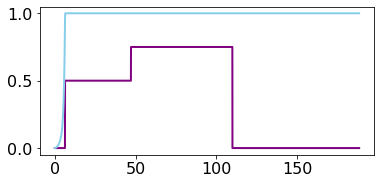

In [208]:
# a = 0.045
Tta, w, me, isd, isq, wrefs = simulateSpeedingUpWithAcceleration2()

print(wrefs)

# print(w)
plotDynamicForSpeedingUp2(Tta, w, me, isd, isq, wrefs)